Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "yuke li"
COLLABORATORS = ""

---

# Problem description

To a large degree, financial data has traditionally been numeric in format.

But in recent years, non-numeric formats like image, text and audio have been introduced.  

Private companies have satellites orbiting the Earth taking photos and offering them to customers.  A financial analyst might be able to extract information from these photos that could aid in the prediction of the future price of a stock

- Approximate number of customers visiting each store: count number of cars in parking lot
- Approximate activity in a factory by counting number of supplier trucks arriving and number of delivery trucks leaving
- Approximate demand for a commodity at each location: count cargo ships traveling between ports

In this assignment, we will attempt to recognize ships in satellite photos.
This would be a first step toward
counting.

As in any other domain: specific knowledge of the problem area will make you a better analyst.

For this assignment, we will ignore domain-specific information and just try to use a labeled training set (photo plus a binary indicator for whether a ship is present/absent in the photo), assuming that the labels are perfect.



## Goal: 

In this notebook, you will need to create a model in `TensorFlow/Keras` to classify satellite photos.
- The features are images: 3 dimensional collection of pixels
  - 2 spatial dimensions
  - 1 dimension with 3 features for different parts of the color spectrum: Red, Green, Blue
- The labels are either 1 (ship is present) or 0 (ship is not present)

There are two notebook files in this assignment:
- The one you are viewing now: First and only notebook you need to work on. 
    - Train your models here
    - There are cells that will save your models to a file
- **`Model_test.ipynb`**:
    - PLEASE IGNORE    

You will create several Keras `Sequential` models, of increasing complexity
- A model that implements only a Classification Head (no transformations other than perhaps rearranging the image)
- A model that adds a Dense layer before the head
- (Later assignment) A model that adds Convolutional layers before the Head

## Learning objectives
- Learn how to construct Neural Networks using Keras Sequential model
- Appreciate how layer choices impact number of weights

# Imports modules

In [2]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

import os
import math

%matplotlib inline


## Import tensorflow and check the version
import tensorflow as tf
from tensorflow.keras.utils import plot_model

print("Running TensorFlow version ",tf.__version__)

# Parse tensorflow version
import re

version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )

Running TensorFlow version  2.12.0
Version 2, minor 12


# API for students

We have defined some utility routines in a file `helper.py`. There is a class named `Helper` in it.  

This will simplify problem solving

More importantly: it adds structure to your submission so that it may be easily graded

`helper = helper.Helper()`

- getData: Get a collection of labeled images, used as follows

  >`data, labels = helper.getData()`
- showData: Visualize labelled images, used as follows

  >`helper.showData(data, labels)`
- plot training results: Visualize training accuracy, loss and validation accuracy, loss

  >`helper.plotTrain(history, modelName)`, where history is the result of model training
- save model: save a model in `./models` directory

  >`helper.saveModel(model, modelName)`
- save history: save a model history in `./models` directory
  >`helper.saveHistory(history, modelName)`

In [3]:
# Load the helper module
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%reload_ext autoreload
%autoreload 1

# Import nn_helper module
import helper
%aimport helper



## You may pass an optional `data_dir` argument to the constructor `helper.Helper`
- if you have your data directory located somewhere other than the default location
- no need to provide an argument otherwise

For example:

        helper = helper.Helper(data_dir="./MyDataDir")

In [4]:
helper = helper.Helper()

# Get the data

The first step in our Recipe is Get the Data.

We have provided a utility method `getData` to simplify this for you

In [5]:
# Get the data
data, labels = helper.getData()
n_samples, width, height, channel = data.shape

print("Data shape: ", data.shape)
print("Labels shape: ", labels.shape)
print("Label values: ", np.unique(labels))



Data shape:  (4000, 80, 80, 3)
Labels shape:  (4000,)
Label values:  [0 1]


We will shuffle the examples before doing anything else.

This is usually a good idea
- Many datasets are naturally arranged in a *non-random* order, e.g., examples with the sample label grouped together
- You want to make sure that, when you split the examples into training and test examples, each split has a similar distribution of examples

In [6]:
# Shuffle the data first
data, labels = sklearn.utils.shuffle(data, labels, random_state=42)

## Have a look at the data

We will not go through all steps in the Recipe, nor in depth.

But here's a peek



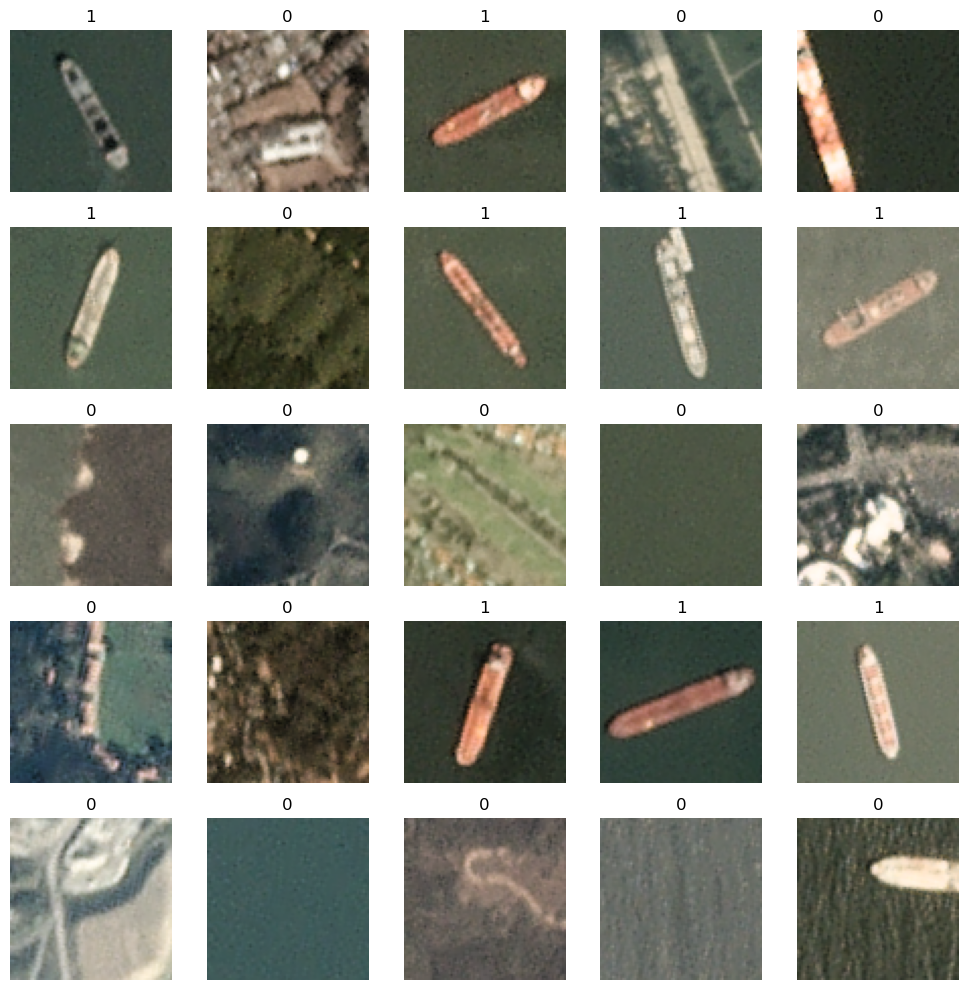

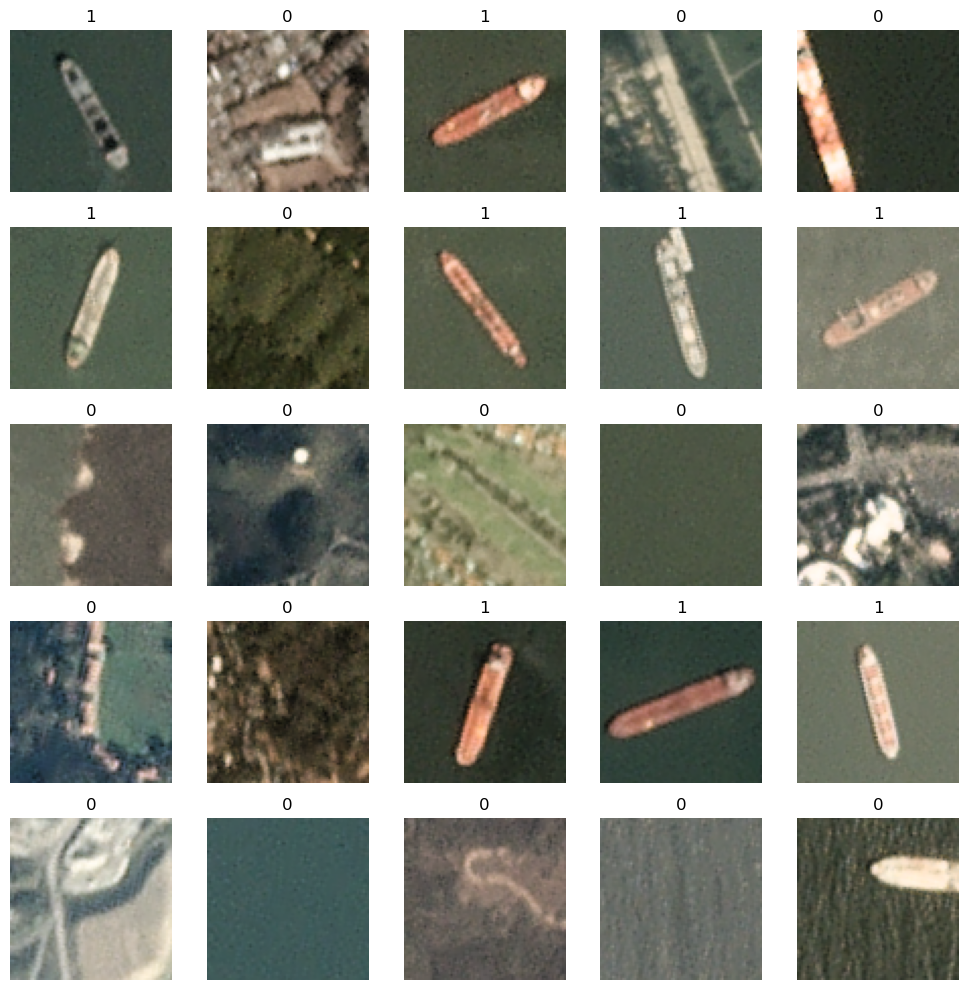

In [7]:
# Visualize the data samples
helper.showData(data[:25], labels[:25])

## Eliminate the color dimension

As a simplification, we will convert the image from color (RGB, with 3 "color" dimensions referred to as Red, Green and Blue) to gray scale.


In [8]:
print("Original shape of data: ", data.shape)

w = (.299, .587, .114)
data_bw = np.sum(data *w, axis=3)

print("New shape of data: ", data_bw.shape)

data_orig = data.copy()

Original shape of data:  (4000, 80, 80, 3)
New shape of data:  (4000, 80, 80)


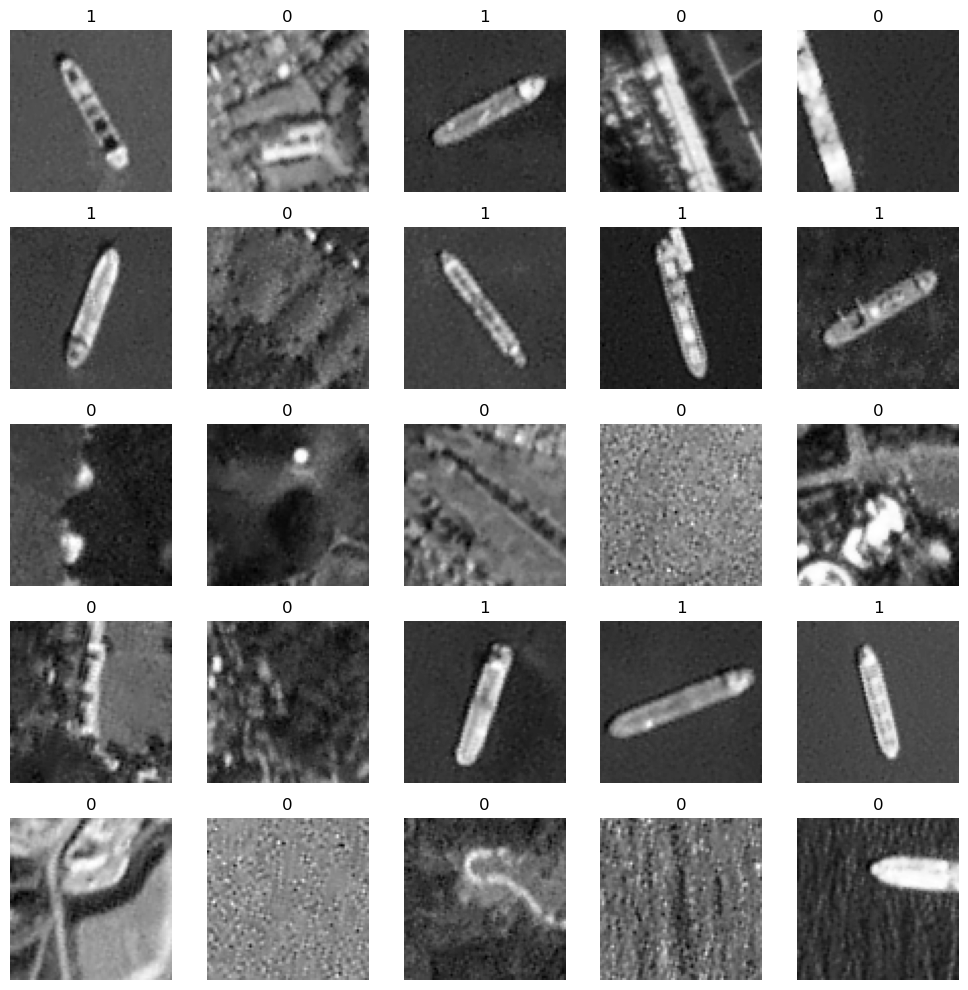

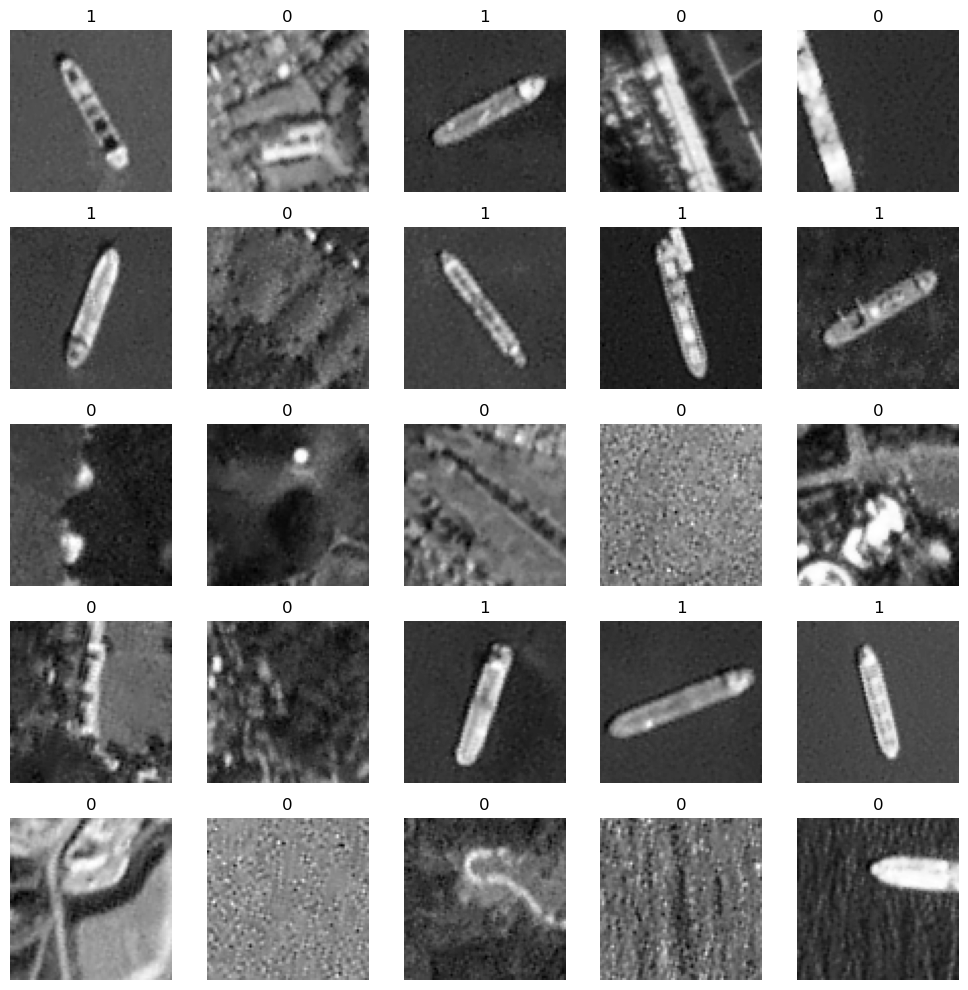

In [9]:
# Visualize the data samples
helper.showData(data_bw[:25], labels[:25], cmap="gray")

## Have  look at the data: Examine the image/label pairs

Rather than viewing the examples in random order, let's group them by label.

Perhaps we will learn something about the characteristics of images that contain ships.

We have loaded and shuffled our dataset, now we will take a look at image/label pairs. 

Feel free to explore the data using your own ideas and techniques.



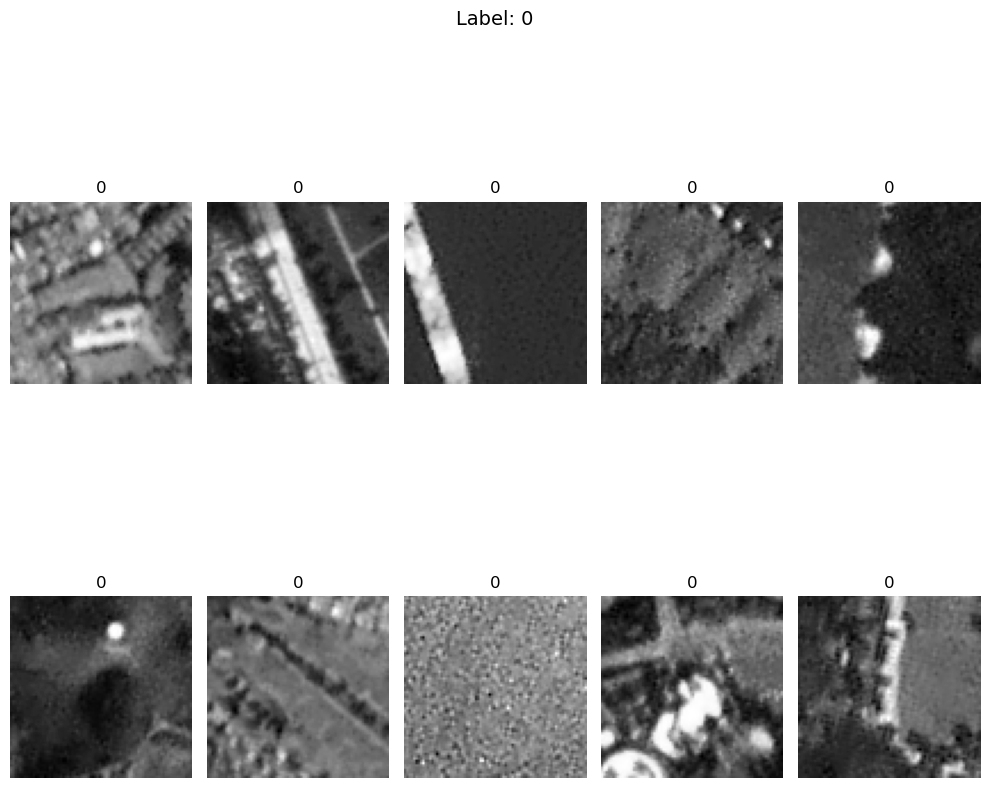

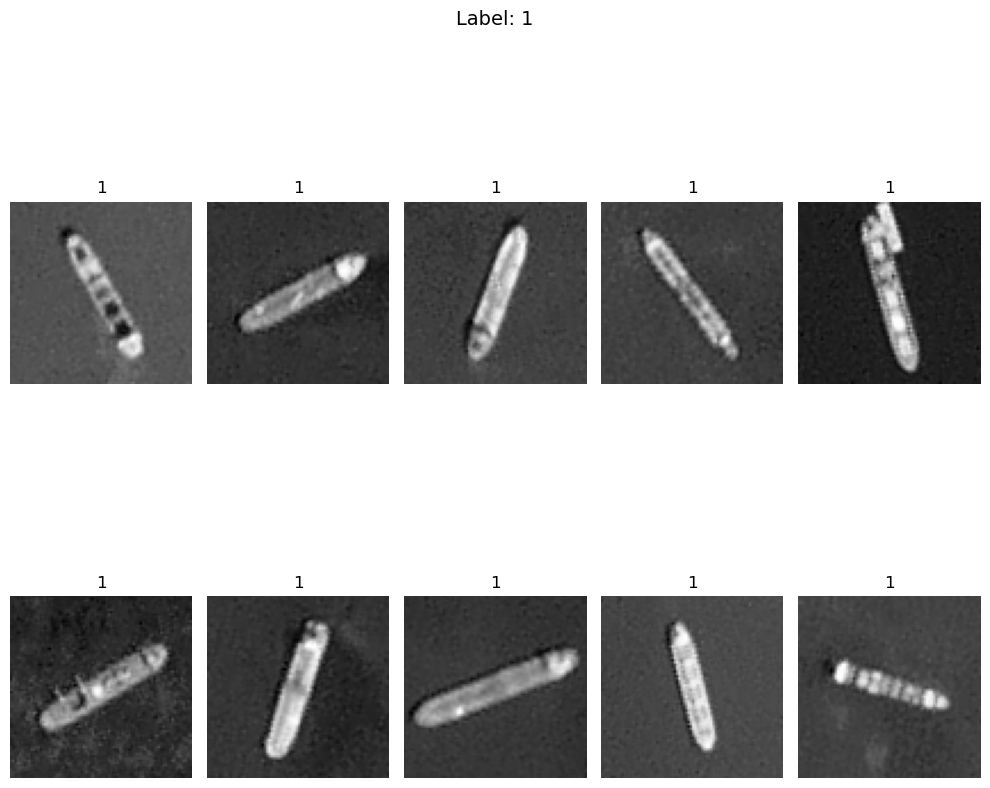

In [10]:
# Inspect some data (images)
num_each_label = 10

for lab in np.unique(labels):
    # Fetch images with different labels
    X_lab, y_lab = data_bw[ labels == lab ], labels[ labels == lab]
    # Display images
    fig = helper.showData( X_lab[:num_each_label], [ str(label) for label in y_lab[:num_each_label] ], cmap="gray")
    _ = fig.suptitle("Label: "+  str(lab), fontsize=14)
    print("\n\n")


# Make sure the features are in the range [0,1]  

**Warm up exercise:** When we want to train image data, the first thing we usually need to do is scaling. 

Since the feature values in our image data are between 0 and 255, to make them between 0 and 1, we need to divide them by 255.  

We also need to consider how to represent our target values
- If there are more than 2 possible target values, One Hot Encoding may be appropriate
    - **Hint**: Lookup `tf.keras.utils.to_categorical`
- If there are only 2 possible targets with values 0 and 1 we can use these targets without further encoding

**Question**
- Set variable `X` to be our gray-scale examples (`data_bw`), but with values in the range [0,1]
- Set variable `y` to be the representation of our target values


In [11]:
# Scale the data
# Assign values for X, y
#  X: the array of features
#  y: the array of labels
# The length of X and y should be identical and equal to the length of data.
from tensorflow.keras.utils import to_categorical
X, y = np.array([]), np.array([])
X = data_bw / 255.0
y = labels
print("X shape:", X.shape)
print("y shape:", y.shape)
# YOUR CODE HERE

#raise NotImplementedError()

X shape: (4000, 80, 80)
y shape: (4000,)


In [12]:
# Check if your solution is right 

assert X.shape == (4000, 80, 80)
assert y.shape == (4000,)


# Split data into training data and testing data
To train and evaluate a model, we need to split the original dataset into
a training subset (in-sample) and a test subset (out of sample).

We will do this for you in the cell below.

**DO NOT** shuffle the data until after we have performed the split into train/test sets
- We want everyone to have the **identical** test set for grading
- Do not change this cell


In [13]:
# Split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Save X_train, X_test, y_train, y_test for final testing
if not os.path.exists('./data'):
    os.mkdir('./data')
np.savez_compressed('./data/train_test_data.npz', X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

# Create a model using only Classification, no data transformation (other than reshaping)

**Question:** You need to build a 1-layer (head layer only) network model with `tensorflow.keras`. Please name the head layer "dense_head".  

Set variable `model0` to be a Keras `Sequential` model object that implements your model.

**Hints:**
1. Since the dataset is 2-dimensional, you may want to use `Flatten()` in `tensorflow.keras.layers` to make your input data 1 dimensional. 
    - The `input shape` argument of the `Flatten()` layer should be the shape of a single example
2. The number of units in your head layer 
    - Depends on how you represented the target
    - It should be equal to the final dimension of  `y`

3. Activation function for the head layer: Since this is a classification problem
    - Use  `sigmoid` if your target's final dimension equals 1
    - Use  `softmax` if your target's final dimension is greater than 1

- A Dropout layer maybe helpful to prevent overfitting and accelerate your training process. 
    - If you want to use a Dropout layer, you can use `Dropout()`, which is in  `tensorflow.keras.layers`. 


In [14]:
# Get the number of unique labels
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
num_cases = np.unique(labels).shape[0]
if num_cases > 2:
    activation = "softmax"
    loss = 'categorical_crossentropy'
else:
    activation = "sigmoid"
    num_cases = 1
    loss = 'binary_crossentropy'
    
# Set model0 equal to a Keras Sequential model
model0 = Sequential()

model0.add(Flatten(input_shape=(80, 80)))  

model0.add(Dense(1, activation='sigmoid', name="dense_head"))

model0.add(Dropout(0.1))

# YOUR CODE HERE
#raise NotImplementedError()

model0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 dense_head (Dense)          (None, 1)                 6401      
                                                                 
 dropout (Dropout)           (None, 1)                 0         
                                                                 
Total params: 6,401
Trainable params: 6,401
Non-trainable params: 0
_________________________________________________________________


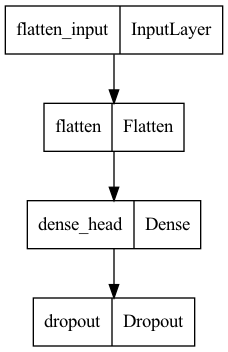

In [15]:
# We can plot our model here using plot_model()
from tensorflow.keras.utils import plot_model
plot_model(model0)

## Train model

**Question:**

Now that you have built your first model, you will compile and train it. The requirements are as follows:

- Split the **training** examples `X_train, y_train` again !
    - 80% will be used for training the model
    - 20% will be used as validation (out of sample) examples
    - Use `train_test_split()` from `sklearn` to perform this split
        -  Set the `random_state` parameter of `train_test_split()` to be 42

- Loss function: 
    - `binary_crossentropy` if your target is one-dimensional
    - `categorical_crossentropy`if your target is One Hot Encoded
- Metric: "accuracy"
- Use exactly 15  epochs for training
- Save your training results in a variable named `history0`
- Plot your training results using the`plotTrain` method described in the Student API above.


Epoch 1/15


2024-10-28 13:17:14.429957: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


90/90 - 0s - loss: 1.0426 - accuracy: 0.7424 - val_loss: 0.4174 - val_accuracy: 0.8139 - 456ms/epoch - 5ms/step
Epoch 2/15
90/90 - 0s - loss: 0.9651 - accuracy: 0.7840 - val_loss: 0.3754 - val_accuracy: 0.8292 - 104ms/epoch - 1ms/step
Epoch 3/15
90/90 - 0s - loss: 0.8316 - accuracy: 0.8118 - val_loss: 0.7610 - val_accuracy: 0.7792 - 63ms/epoch - 701us/step
Epoch 4/15
90/90 - 0s - loss: 0.7978 - accuracy: 0.8163 - val_loss: 1.0779 - val_accuracy: 0.7625 - 103ms/epoch - 1ms/step
Epoch 5/15
90/90 - 0s - loss: 0.8518 - accuracy: 0.8201 - val_loss: 1.2902 - val_accuracy: 0.7597 - 90ms/epoch - 1ms/step
Epoch 6/15
90/90 - 0s - loss: 0.8090 - accuracy: 0.8340 - val_loss: 0.3285 - val_accuracy: 0.8625 - 93ms/epoch - 1ms/step
Epoch 7/15
90/90 - 0s - loss: 0.8180 - accuracy: 0.8264 - val_loss: 0.3251 - val_accuracy: 0.8597 - 63ms/epoch - 703us/step
Epoch 8/15
90/90 - 0s - loss: 0.7837 - accuracy: 0.8309 - val_loss: 0.3773 - val_accuracy: 0.8597 - 59ms/epoch - 659us/step
Epoch 9/15
90/90 - 0s - lo

(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: title={'center': 'Head only model loss'}, xlabel='epoch', ylabel='loss'>,
        <Axes: title={'center': 'Head only model accuracy'}, xlabel='epoch', ylabel='accuracy'>],
       dtype=object))

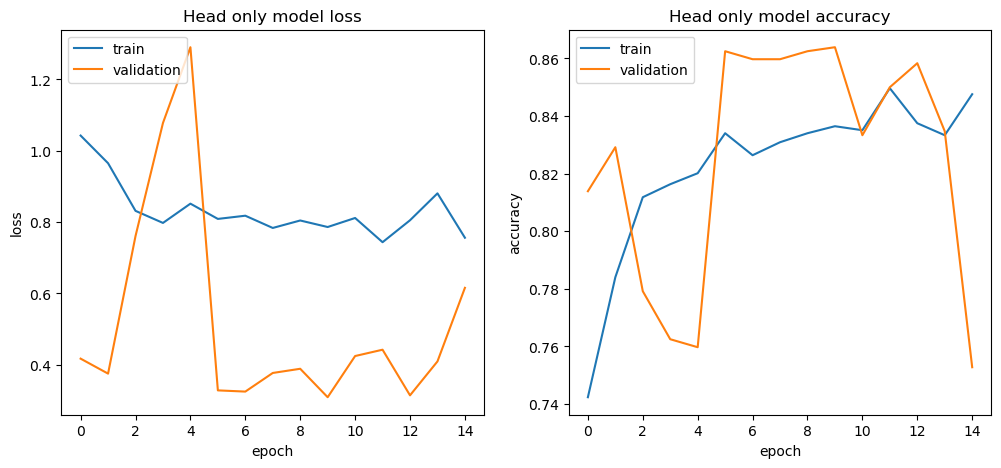

In [16]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
model_name0 = "Head only"
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

model0.compile(loss='binary_crossentropy', metrics=['accuracy'])

history0 = model0.fit(X_train_split, y_train_split, 
                      validation_data=(X_val_split, y_val_split), 
                      epochs=15, 
                      verbose=2)

helper.plotTrain(history0, "Head only")
#raise NotImplementedError()

## How many weights in the model ?

**Question:** 

Calculate the number of parameters in your model.  

Set variable `num_parameters0` to be equal to the number of parameters in your model.

**Hint:** The model object may have a method to help you ! Remember that Jupyter can help you find the methods that an object implements.


In [17]:
# Set num_parameters0 equal to the number of weights in the model
num_parameters0 = None
num_parameters0 = model0.count_params()

#raise NotImplementedError()

print("Parameters number in model0: ", num_parameters0)

Parameters number in model0:  6401


## Evaluate the model

**Question:**

We have trained our model. We now need to  evaluate the model using the test dataset created in an earlier cell.

Please store the model score in a variable named `score0`.   

**Hint:** The model object has a method  `evaluate`.  Use that to compute the score.

In [18]:
score0 = []
score0 = model0.evaluate(X_test, y_test, verbose=0)
# YOUR CODE HERE
#raise NotImplementedError()

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name0, l=score0[0], a=score0[1]))

Head only: Test loss: 0.65 / Test accuracy: 0.74


## Save the trained model0 and history0 for submission

Your fitted model can be saved for later use
- In general: so you can resume training at a later time
- In particular: to allow us to grade it !

Execute the following cell to save your model, which you will submit to us for grading.

In [19]:
helper.saveModel(model0, model_name0)
helper.saveHistory(history0, model_name0)

Model saved in ./models/Head only.keras; submit with your assignment.


**Question:**

Make sure that the saved model can be successfully restored.
- Set variable `model_loss` to the value of the loss parameter you used in the `compile` statement for your model
- Set variable `model_metrics` to the value of the metrics parameter you used in the `compile` statement for  your model

In [20]:
## Restore the model (make sure that it works)

model_loss = 'binary_crossentropy'
model_metrics = ['accuracy']

# YOUR CODE HERE
#raise NotImplementedError()

model_loaded = helper.loadModel(model_name0, loss=model_loss, metrics=model_metrics)
score_loaded = model_loaded.evaluate(X_test, y_test, verbose=0)

assert score_loaded[0] == score0[0] and score_loaded[1] == score0[1]

# Create a new model with an additional Dense layer 

**Question:** 

We will add more layers to the original model0. 

- You need to add **AT LEAST ONE** Dense layer followed by an activation function (for example, ReLU)
    - You can add more layers if you like
    
- The number of units in your very **FIRST** Dense layer should be equal to the value of variable `num_features_1`, as set below.
    - Please name this Dense layer "dense_1" and the head layer "dense_head". 

**Hints:**
- Don't forget to flatten your input data!
- A Dropout layer maybe helpful to prevent overfitting and accelerate your training process. 
    - If you want to use a Dropout layer, you can use `Dropout()`, which is in  `tensorflow.keras.layers`. 

Hopefully your new model performs **better** than your first.

In [21]:
# Set model1 equal to a Keras Sequential model
model1 = None
num_features_1 = 64
model1 = Sequential([
    Flatten(input_shape=(80, 80, 1)),  
    Dense(num_features_1, activation='relu', name="dense_1"),
    Dropout(0.1),  
    Dense(1, activation='sigmoid', name="dense_head")  
])
# YOUR CODE HERE
#raise NotImplementedError()

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 6400)              0         
                                                                 
 dense_1 (Dense)             (None, 64)                409664    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_head (Dense)          (None, 1)                 65        
                                                                 
Total params: 409,729
Trainable params: 409,729
Non-trainable params: 0
_________________________________________________________________


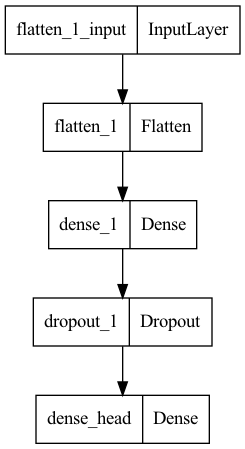

In [22]:
# Plot your model
plot_model(model1)

## Train your new model

**Question:**

Now that you have built your new model1,  you will compile and train model1. The requirements are as follows:

- Split the **training** examples `X_train, y_train` again !
    - 80% will be used for training the model
    - 20% will be used as validation (out of sample) examples
    - Use `train_test_split()` from `sklearn` to perform this split
        -  Set the `random_state` parameter of `train_test_split()` to be 42

- Loss function and Metric as per first model's instructions.
- Use exactly 15  epochs for training
- Save your training results in a variable named `history1`
- Plot your training results using the`plotTrain` method described in the Student API above.


Epoch 1/15
90/90 - 0s - loss: 0.6470 - accuracy: 0.7392 - val_loss: 0.4535 - val_accuracy: 0.7472 - 488ms/epoch - 5ms/step
Epoch 2/15
90/90 - 0s - loss: 0.4649 - accuracy: 0.7979 - val_loss: 0.4321 - val_accuracy: 0.8278 - 224ms/epoch - 2ms/step
Epoch 3/15
90/90 - 0s - loss: 0.4393 - accuracy: 0.8156 - val_loss: 0.4241 - val_accuracy: 0.8097 - 239ms/epoch - 3ms/step
Epoch 4/15
90/90 - 0s - loss: 0.4187 - accuracy: 0.8219 - val_loss: 0.4455 - val_accuracy: 0.8194 - 221ms/epoch - 2ms/step
Epoch 5/15
90/90 - 0s - loss: 0.4110 - accuracy: 0.8281 - val_loss: 0.3741 - val_accuracy: 0.8333 - 235ms/epoch - 3ms/step
Epoch 6/15
90/90 - 0s - loss: 0.4083 - accuracy: 0.8306 - val_loss: 0.3874 - val_accuracy: 0.8444 - 217ms/epoch - 2ms/step
Epoch 7/15
90/90 - 0s - loss: 0.3954 - accuracy: 0.8354 - val_loss: 0.3919 - val_accuracy: 0.8403 - 235ms/epoch - 3ms/step
Epoch 8/15
90/90 - 0s - loss: 0.3860 - accuracy: 0.8392 - val_loss: 0.4058 - val_accuracy: 0.8333 - 242ms/epoch - 3ms/step
Epoch 9/15
90/90

(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: title={'center': 'Dense + Head model loss'}, xlabel='epoch', ylabel='loss'>,
        <Axes: title={'center': 'Dense + Head model accuracy'}, xlabel='epoch', ylabel='accuracy'>],
       dtype=object))

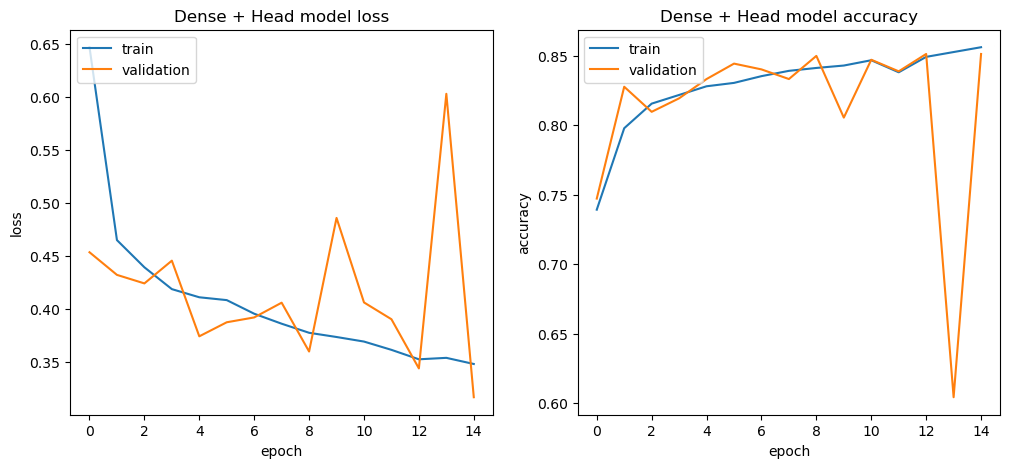

In [23]:
# Train the model using the API
model_name1 = "Dense + Head"
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

model1.compile( loss='binary_crossentropy', metrics=['accuracy'])

history1 = model1.fit(
    X_train_split, y_train_split,
    validation_data=(X_val_split, y_val_split),
    epochs=15,
    verbose=2
)

helper.plotTrain(history1, model_name1)
# YOUR CODE HERE
#raise NotImplementedError()

## How many weights in this model ?

**Question:** Calculate the number of parameters in your new model.  

Set variable `num_parameters1` to be equal to the number of parameters in your model.

In [24]:
# Set num_parameters1 equal to the number of weights in the model
num_parameters1 = None

# YOUR CODE HERE
#raise NotImplementedError()
num_parameters1 = model1.count_params()
print('Parameters number in model1:', num_parameters1)

Parameters number in model1: 409729


## Evaluate the model

**Question:**

Evaluate the new model using the test dataset. Please store the model score in a variable named `score1`.   

In [25]:
score1 = []

score1 = model1.evaluate(X_test, y_test, verbose=0)
#raise NotImplementedError()

print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name1, l=score1[0], a=score1[1]))

Dense + Head: Test loss: 0.30 / Test accuracy: 0.89


Your new test score should be at least 0.8

# Save your trained model1 and history1

In [26]:
helper.saveModel(model1, model_name1)
helper.saveHistory(history1, model_name1)

Directory models already exists, files will be over-written.
Model saved in ./models/Dense + Head.keras; submit with your assignment.


## Your own model (Optional)
Now you can build your own model using what you have learned from the course. Some ideas to try:
- Try more than one additional `Dense` layer 
- Change the number of units (features) of your `Dense` layers. 
- Add `Dropout` layers; vary the parameter 
- Change the activation function
- Change the classifier
- ...

Observe the effect of each change on the Loss and Accuracy.

- You may want to use early stopping in training
    - In order to stop training when model metrics *worsen* rather than *improve*


In [27]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

### Idea 1: Try more than one additional dense layer 
This model, named model2, is a sequential neural network designed for binary classification, processing grayscale images with dimensions 80×80. The model begins with a Flatten layer that reshapes each input image from 80×80×1
to a one-dimensional vector of 6400 elements. Following this, there are three Dense layers, each containing 64 neurons with ReLU activations, enabling the model to capture complex patterns and nuances in the data. To prevent overfitting, a Dropout layer is included after the third Dense layer, randomly setting 10% of neurons to zero during training. The final layer is a Dense output layer with a single neuron and a sigmoid activation, providing a probability score between 0 and 1 for binary classification, where values close to 1 indicate one class and values close to 0 indicate the other. 

In [28]:
model_name2="model2"
model2 = Sequential([
    Flatten(input_shape=(80, 80, 1)),  
    Dense(64, activation='relu', name='dense_1'),
    Dense(64, activation='relu', name='dense_2'),
    Dense(64, activation='relu', name='dense_3'),
    Dropout(0.1),
    Dense(1, activation='sigmoid', name='dense_head') 
])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 6400)              0         
                                                                 
 dense_1 (Dense)             (None, 64)                409664    
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_head (Dense)          (None, 1)                 65        
                                                                 
Total params: 418,049
Trainable params: 418,049
Non-tr

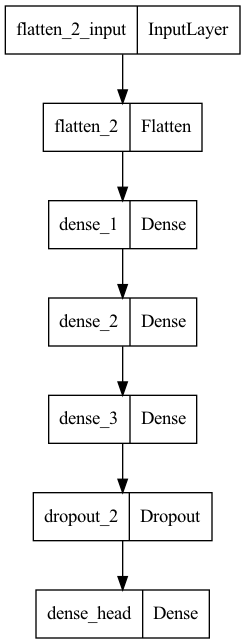

In [29]:
plot_model(model2)

Epoch 1/50
90/90 - 1s - loss: 0.5702 - accuracy: 0.7361 - val_loss: 0.4674 - val_accuracy: 0.8236 - 643ms/epoch - 7ms/step
Epoch 2/50
90/90 - 0s - loss: 0.4574 - accuracy: 0.8087 - val_loss: 0.3695 - val_accuracy: 0.8347 - 239ms/epoch - 3ms/step
Epoch 3/50
90/90 - 0s - loss: 0.4093 - accuracy: 0.8257 - val_loss: 0.3441 - val_accuracy: 0.8431 - 299ms/epoch - 3ms/step
Epoch 4/50
90/90 - 0s - loss: 0.4009 - accuracy: 0.8333 - val_loss: 0.3315 - val_accuracy: 0.8403 - 234ms/epoch - 3ms/step
Epoch 5/50
90/90 - 0s - loss: 0.3733 - accuracy: 0.8455 - val_loss: 0.3404 - val_accuracy: 0.8486 - 248ms/epoch - 3ms/step
Epoch 6/50
90/90 - 0s - loss: 0.3660 - accuracy: 0.8514 - val_loss: 0.3006 - val_accuracy: 0.8667 - 226ms/epoch - 3ms/step
Epoch 7/50
90/90 - 0s - loss: 0.3434 - accuracy: 0.8510 - val_loss: 0.4472 - val_accuracy: 0.8556 - 244ms/epoch - 3ms/step
Epoch 8/50
90/90 - 0s - loss: 0.3425 - accuracy: 0.8510 - val_loss: 0.3120 - val_accuracy: 0.8597 - 226ms/epoch - 3ms/step
Epoch 9/50
90/90

(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: title={'center': 'model2 model loss'}, xlabel='epoch', ylabel='loss'>,
        <Axes: title={'center': 'model2 model accuracy'}, xlabel='epoch', ylabel='accuracy'>],
       dtype=object))

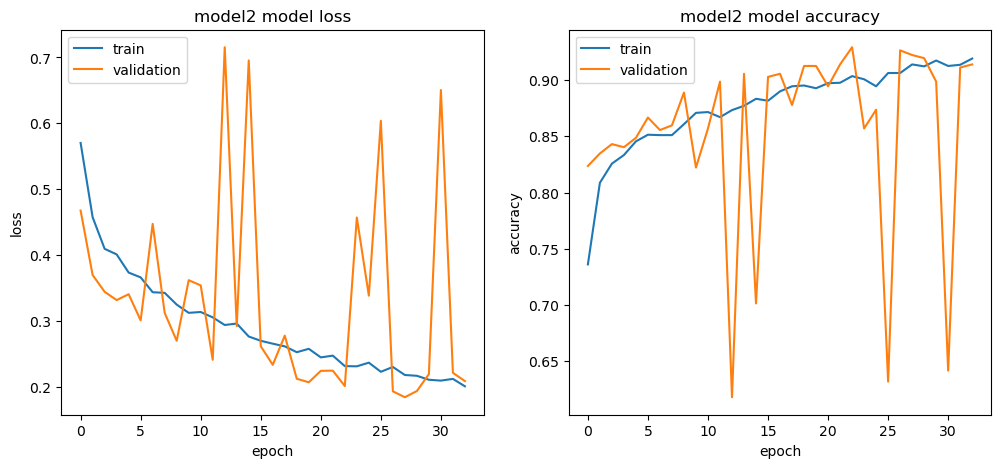

In [30]:
model2.compile( loss='binary_crossentropy', metrics=['accuracy'])

history2 = model2.fit(
    X_train_split, y_train_split,
    validation_data=(X_val_split, y_val_split),
    epochs=50,
    callbacks=[early_stop],
    verbose=2
)

helper.plotTrain(history2, model_name2)

In [31]:
score2 = model2.evaluate(X_test, y_test, verbose=0)
print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name2, l=score2[0], a=score2[1]))

model2: Test loss: 0.19 / Test accuracy: 0.92


The results for model2 indicate a strong performance, with a test loss of 0.19 and test accuracy of 0.92.  The training loss consistently decreases over the epochs, showing effective learning.  However, the validation loss shows noticeable fluctuations, with some sharp spikes, suggesting potential instability. 

In [32]:
helper.saveModel(model2, model_name2)
helper.saveHistory(history2, model_name2)

Directory models already exists, files will be over-written.
Model saved in ./models/model2.keras; submit with your assignment.


### Idea 2: Change the number of units (features) of your Dense layers
This model is a sequential neural network designed for binary classification tasks, consisting of several layers. It begins with a Flatten layer to convert the input 2D image data (80x80 pixels with 1 channel) into a 1D array. The first Dense layer (dense_1) has 128 neurons with a ReLU activation function to learn high-level features from the flattened input. This is followed by two additional Dense layers (dense_2 and dense_3), each with 64 neurons and ReLU activations, which further refine the learned features. A Dropout layer with a rate of 0.1 is included to randomly disable 10% of neurons during training, helping to prevent overfitting and enhance generalization. The final Dense layer (dense_head) has 1 neuron with a sigmoid activation, outputting a probability score between 0 and 1. 


In [33]:
model_name3="model3"
model3 = Sequential([
    Flatten(input_shape=(80, 80, 1)),
    Dense(128, activation='relu', name='dense_1'),  
    Dense(64, activation='relu', name='dense_2'),   
    Dense(64, activation='relu', name='dense_3'),  
    Dropout(0.1),
    Dense(1, activation='sigmoid', name='dense_head')
])
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 6400)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               819328    
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_head (Dense)          (None, 1)                 65        
                                                                 
Total params: 831,809
Trainable params: 831,809
Non-tr

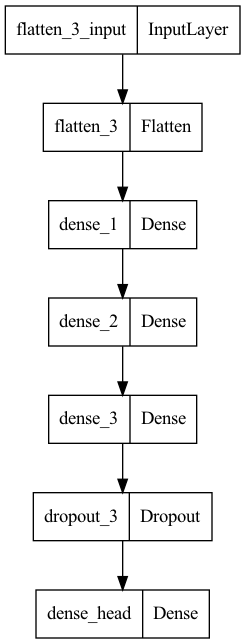

In [34]:
plot_model(model3)

Epoch 1/50
90/90 - 1s - loss: 0.7005 - accuracy: 0.6913 - val_loss: 0.4722 - val_accuracy: 0.7833 - 616ms/epoch - 7ms/step
Epoch 2/50
90/90 - 0s - loss: 0.4996 - accuracy: 0.7878 - val_loss: 0.4287 - val_accuracy: 0.7944 - 352ms/epoch - 4ms/step
Epoch 3/50
90/90 - 0s - loss: 0.4206 - accuracy: 0.8139 - val_loss: 0.3849 - val_accuracy: 0.8264 - 350ms/epoch - 4ms/step
Epoch 4/50
90/90 - 0s - loss: 0.4150 - accuracy: 0.8174 - val_loss: 0.3973 - val_accuracy: 0.8444 - 344ms/epoch - 4ms/step
Epoch 5/50
90/90 - 0s - loss: 0.3833 - accuracy: 0.8392 - val_loss: 0.3348 - val_accuracy: 0.8458 - 333ms/epoch - 4ms/step
Epoch 6/50
90/90 - 0s - loss: 0.3666 - accuracy: 0.8472 - val_loss: 0.3033 - val_accuracy: 0.8556 - 331ms/epoch - 4ms/step
Epoch 7/50
90/90 - 0s - loss: 0.3753 - accuracy: 0.8378 - val_loss: 0.3311 - val_accuracy: 0.8486 - 340ms/epoch - 4ms/step
Epoch 8/50
90/90 - 0s - loss: 0.3531 - accuracy: 0.8476 - val_loss: 0.3088 - val_accuracy: 0.8375 - 316ms/epoch - 4ms/step
Epoch 9/50
90/90

(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: title={'center': 'model3 model loss'}, xlabel='epoch', ylabel='loss'>,
        <Axes: title={'center': 'model3 model accuracy'}, xlabel='epoch', ylabel='accuracy'>],
       dtype=object))

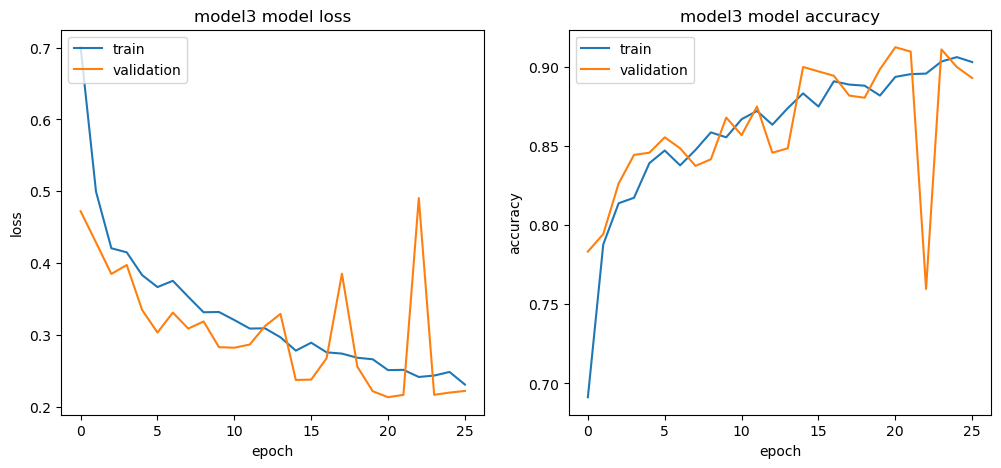

In [35]:
model3.compile( loss='binary_crossentropy', metrics=['accuracy'])

history3 = model3.fit(
    X_train_split, y_train_split,
    validation_data=(X_val_split, y_val_split),
    epochs=50,
    callbacks=[early_stop],
    verbose=2
)

helper.plotTrain(history3, model_name3)

In [36]:
score3 = model3.evaluate(X_test, y_test, verbose=0)
print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name3, l=score3[0], a=score3[1]))

model3: Test loss: 0.21 / Test accuracy: 0.90


The evaluation of model3 shows a test loss of 0.21 and test accuracy of 0.90.  The training and validation losses both decrease steadily, indicating effective learning, though the validation loss exhibits some fluctuations and occasional spikes, which may hint at minor instability.  

In [37]:
helper.saveModel(model3, model_name3)
helper.saveHistory(history3, model_name3)

Directory models already exists, files will be over-written.
Model saved in ./models/model3.keras; submit with your assignment.


### Idea 3: Add Dropout layers; vary the parameter
Model4 is a sequential neural network designed for binary classification.  It starts with a Flatten layer to convert the input from an 80x80 grayscale image into a 1D vector.  The model has three hidden Dense layers with 256, 128, and 64 units, each using the ReLU activation function, followed by a Dropout layer with a 0.1 dropout rate to prevent overfitting.  The final layer is a Dense layer with a single unit and a sigmoid activation function. 

In [38]:
model_name4="model4"
model4 = Sequential([
    Flatten(input_shape=(80, 80, 1)),
    Dense(256, activation='relu', name='dense_1'), 
    Dropout(0.1),
    Dense(128, activation='relu', name='dense_2'), 
    Dropout(0.1),
    Dense(64, activation='relu', name='dense_3'),  
    Dropout(0.1),
    Dense(1, activation='sigmoid', name='dense_head')
])
model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 6400)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               1638656   
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_6 (Dropout)         (None, 64)               

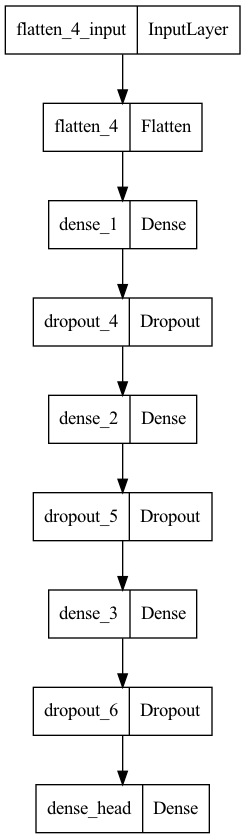

In [39]:
plot_model(model4)

Epoch 1/50
90/90 - 1s - loss: 0.8363 - accuracy: 0.6948 - val_loss: 0.5027 - val_accuracy: 0.7556 - 902ms/epoch - 10ms/step
Epoch 2/50
90/90 - 1s - loss: 0.5438 - accuracy: 0.7559 - val_loss: 0.4262 - val_accuracy: 0.8083 - 596ms/epoch - 7ms/step
Epoch 3/50
90/90 - 1s - loss: 0.4654 - accuracy: 0.8017 - val_loss: 0.5369 - val_accuracy: 0.7917 - 578ms/epoch - 6ms/step
Epoch 4/50
90/90 - 1s - loss: 0.4328 - accuracy: 0.8177 - val_loss: 0.3518 - val_accuracy: 0.8444 - 578ms/epoch - 6ms/step
Epoch 5/50
90/90 - 1s - loss: 0.3905 - accuracy: 0.8288 - val_loss: 0.3687 - val_accuracy: 0.8528 - 548ms/epoch - 6ms/step
Epoch 6/50
90/90 - 1s - loss: 0.3817 - accuracy: 0.8403 - val_loss: 0.3239 - val_accuracy: 0.8556 - 562ms/epoch - 6ms/step
Epoch 7/50
90/90 - 1s - loss: 0.3730 - accuracy: 0.8465 - val_loss: 0.3050 - val_accuracy: 0.8597 - 550ms/epoch - 6ms/step
Epoch 8/50
90/90 - 1s - loss: 0.3632 - accuracy: 0.8528 - val_loss: 0.3482 - val_accuracy: 0.8528 - 601ms/epoch - 7ms/step
Epoch 9/50
90/9

(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: title={'center': 'model4 model loss'}, xlabel='epoch', ylabel='loss'>,
        <Axes: title={'center': 'model4 model accuracy'}, xlabel='epoch', ylabel='accuracy'>],
       dtype=object))

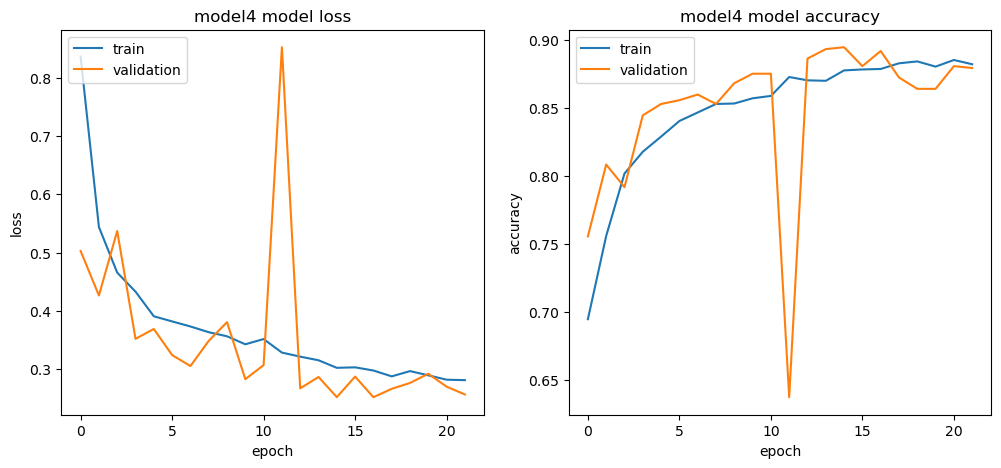

In [40]:
model4.compile( loss='binary_crossentropy', metrics=['accuracy'])
history4 = model4.fit(
    X_train_split, y_train_split,
    validation_data=(X_val_split, y_val_split),
    epochs=50,
    callbacks=[early_stop],
    verbose=2
)

helper.plotTrain(history4, model_name4)

In [41]:
score4 = model4.evaluate(X_test, y_test, verbose=0)
print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name4, l=score4[0], a=score4[1]))

model4: Test loss: 0.26 / Test accuracy: 0.89


For Model4, the training and validation loss curves show a steady decrease overall, though there is some fluctuation in validation loss, particularly a spike around the 10th epoch.  However, the validation loss stabilizes well afterward.  The accuracy plot shows an improvement in both training and validation accuracy, with validation accuracy generally tracking close to the training accuracy.  The final test results show a loss of 0.26 and an accuracy of 0.89, indicating that the model generalizes reasonably well to the test data. 

In [42]:
helper.saveModel(model4, model_name4)
helper.saveHistory(history4, model_name4)

Directory models already exists, files will be over-written.
Model saved in ./models/model4.keras; submit with your assignment.


### Idea 4: Change the activation function
Model5 consists of a sequential architecture where the input is first flattened from an 80x80 grayscale image into a 1D vector. The model has three dense layers with 256, 128, and 64 neurons, respectively.   The first two dense layers use the ReLU activation function, while the third uses the Tanh activation, likely to provide some non-linearity and handle both positive and negative values effectively. Each dense layer is followed by a Dropout layer with a 0.1 rate to prevent overfitting. The final layer has a single neuron with a Sigmoid activation, making this model suitable for binary classification tasks.


In [43]:
model_name5="model5"
model5 = Sequential([
    Flatten(input_shape=(80, 80, 1)),
    Dense(256, activation='relu', name='dense_1'), 
    Dropout(0.1),
    Dense(128, activation='relu', name='dense_2'), 
    Dropout(0.1),
    Dense(64, activation='tanh', name='dense_3'),  
    Dropout(0.1),
    Dense(1, activation='sigmoid', name='dense_head')
])
model5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 6400)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               1638656   
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_9 (Dropout)         (None, 64)               

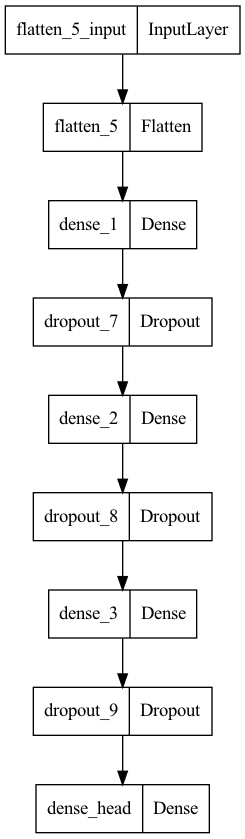

In [44]:
plot_model(model5)

Epoch 1/100
90/90 - 1s - loss: 0.5718 - accuracy: 0.7385 - val_loss: 0.4506 - val_accuracy: 0.7708 - 906ms/epoch - 10ms/step
Epoch 2/100
90/90 - 1s - loss: 0.4822 - accuracy: 0.7819 - val_loss: 0.4800 - val_accuracy: 0.8250 - 574ms/epoch - 6ms/step
Epoch 3/100
90/90 - 1s - loss: 0.4338 - accuracy: 0.8132 - val_loss: 0.4978 - val_accuracy: 0.8083 - 562ms/epoch - 6ms/step
Epoch 4/100
90/90 - 1s - loss: 0.4264 - accuracy: 0.8101 - val_loss: 0.4583 - val_accuracy: 0.8167 - 569ms/epoch - 6ms/step
Epoch 5/100
90/90 - 1s - loss: 0.4059 - accuracy: 0.8226 - val_loss: 0.3269 - val_accuracy: 0.8347 - 558ms/epoch - 6ms/step
Epoch 6/100
90/90 - 1s - loss: 0.4016 - accuracy: 0.8281 - val_loss: 0.3352 - val_accuracy: 0.8431 - 538ms/epoch - 6ms/step
Epoch 7/100
90/90 - 1s - loss: 0.3725 - accuracy: 0.8365 - val_loss: 0.3602 - val_accuracy: 0.8278 - 530ms/epoch - 6ms/step
Epoch 8/100
90/90 - 1s - loss: 0.3727 - accuracy: 0.8458 - val_loss: 0.3182 - val_accuracy: 0.8542 - 537ms/epoch - 6ms/step
Epoch 9

(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: title={'center': 'model5 model loss'}, xlabel='epoch', ylabel='loss'>,
        <Axes: title={'center': 'model5 model accuracy'}, xlabel='epoch', ylabel='accuracy'>],
       dtype=object))

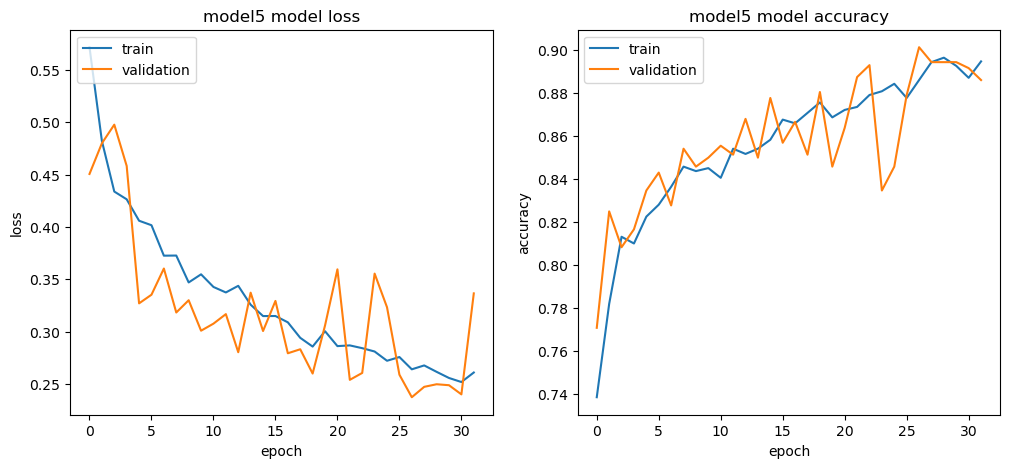

In [45]:
model5.compile( loss='binary_crossentropy', metrics=['accuracy'])
history5 = model5.fit(
    X_train_split, y_train_split,
    validation_data=(X_val_split, y_val_split),
    epochs=100,
    callbacks=[early_stop],
    verbose=2
)

helper.plotTrain(history5, model_name5)

In [46]:
score5 = model5.evaluate(X_test, y_test, verbose=0)
print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name5, l=score5[0], a=score5[1]))

model5: Test loss: 0.25 / Test accuracy: 0.89


Model5 shows a consistent decrease in both training and validation loss over the epochs, indicating effective learning and a lack of major overfitting.  The accuracy curves for training and validation also trend upward, reaching around 0.89 for the test set.  The test loss of 0.25 and test accuracy of 0.89 suggest that the model generalizes well to new data.  Despite some fluctuations in the validation accuracy, the model appears to have achieved stable performance.

In [47]:
helper.saveModel(model5, model_name5)
helper.saveHistory(history5, model_name5)

Directory models already exists, files will be over-written.
Model saved in ./models/model5.keras; submit with your assignment.


### Idea 5: Change the classifier
Model6 is a neural network designed for classification tasks.  It begins by flattening the input image of shape (80, 80, 1) into a single vector.  This is followed by three dense layers with 256, 128, and 64 units respectively, each using the ReLU activation function and accompanied by Dropout layers to reduce overfitting by randomly deactivating 10% of the neurons.  The final layer has 2 units with a Softmax activation function, making it suitable for binary classification.  The Softmax layer ensures that the output provides probabilities for each class, summing up to 1.

In [48]:
model_name6="model6"
model6 = Sequential([
    Flatten(input_shape=(80, 80, 1)),
    Dense(256, activation='relu', name='dense_1'), 
    Dropout(0.1),
    Dense(128, activation='relu', name='dense_2'), 
    Dropout(0.1),
    Dense(64, activation='relu', name='dense_3'),  
    Dropout(0.1),
    Dense(2, activation='Softmax', name='dense_head')
])
model6.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 6400)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               1638656   
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_12 (Dropout)        (None, 64)               

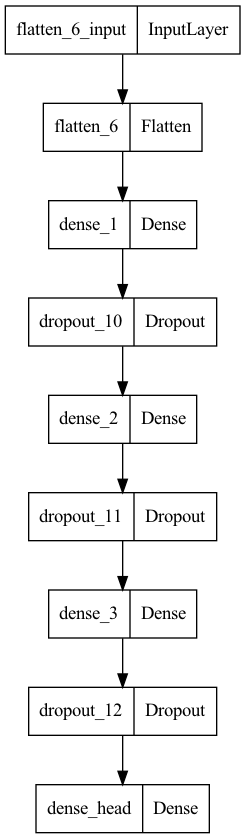

In [49]:
plot_model(model6)

Epoch 1/100
90/90 - 1s - loss: 1.0479 - accuracy: 0.4958 - val_loss: 0.6931 - val_accuracy: 0.4042 - 946ms/epoch - 11ms/step
Epoch 2/100
90/90 - 1s - loss: 0.6955 - accuracy: 0.5135 - val_loss: 0.6931 - val_accuracy: 0.7444 - 576ms/epoch - 6ms/step
Epoch 3/100
90/90 - 1s - loss: 0.6932 - accuracy: 0.5240 - val_loss: 0.6931 - val_accuracy: 0.2528 - 569ms/epoch - 6ms/step
Epoch 4/100
90/90 - 1s - loss: 0.6932 - accuracy: 0.5014 - val_loss: 0.6931 - val_accuracy: 0.7472 - 573ms/epoch - 6ms/step
Epoch 5/100
90/90 - 1s - loss: 0.6932 - accuracy: 0.5017 - val_loss: 0.6931 - val_accuracy: 0.7472 - 591ms/epoch - 7ms/step
Epoch 6/100
90/90 - 1s - loss: 0.6932 - accuracy: 0.5288 - val_loss: 0.6931 - val_accuracy: 0.2528 - 569ms/epoch - 6ms/step
Epoch 7/100
90/90 - 1s - loss: 0.6932 - accuracy: 0.5090 - val_loss: 0.6931 - val_accuracy: 0.7472 - 542ms/epoch - 6ms/step
Epoch 8/100
90/90 - 1s - loss: 0.6932 - accuracy: 0.4722 - val_loss: 0.6931 - val_accuracy: 0.7472 - 566ms/epoch - 6ms/step
Epoch 9

(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: title={'center': 'model6 model loss'}, xlabel='epoch', ylabel='loss'>,
        <Axes: title={'center': 'model6 model accuracy'}, xlabel='epoch', ylabel='accuracy'>],
       dtype=object))

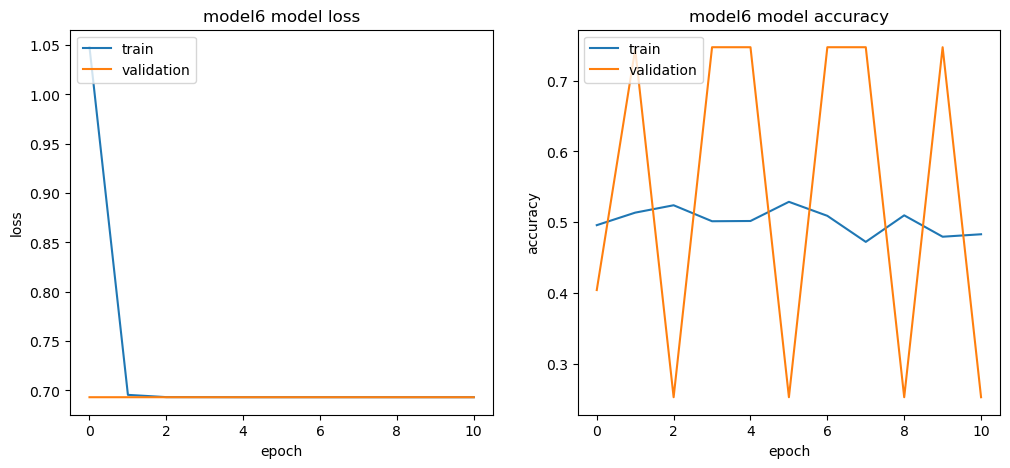

In [50]:
model6.compile( loss='binary_crossentropy', metrics=['accuracy'])
history6 = model6.fit(
    X_train_split, y_train_split,
    validation_data=(X_val_split, y_val_split),
    epochs=100,
    callbacks=[early_stop],
    verbose=2
)

helper.plotTrain(history6, model_name6)

In [51]:
score6 = model6.evaluate(X_test, y_test, verbose=0)
print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name6, l=score6[0], a=score6[1]))

model6: Test loss: 0.69 / Test accuracy: 0.22


The performance of Model6 is not satisfactory. The training and validation loss drop significantly within the first epoch, and then both remain flat, indicating that the model might not learn meaningful features from the data. Additionally, the training accuracy is low and stable around 50%, while the validation accuracy fluctuates dramatically between 0% and 100%. The test results, with a high loss of 0.69 and a poor accuracy of 22%, indicating that the model is not effective for the classification task.

In [52]:
helper.saveModel(model6, model_name6)
helper.saveHistory(history6, model_name6)

Directory models already exists, files will be over-written.
Model saved in ./models/model6.keras; submit with your assignment.


### Idea 6: Try Convolutional layers
Model7 is a convolutional neural network for grayscale images (80x80) aimed at binary classification. It has three convolutional layers with 32, 64, and 128 filters, each followed by 2x2 max-pooling to reduce spatial dimensions. After flattening, there’s a dense layer with 64 units, followed by a 10% dropout to reduce overfitting. The final layer is a single neuron with sigmoid activation, outputting a probability for binary classification. This design leverages convolutional layers to capture spatial features, enhancing its effectiveness for image-based tasks.

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [54]:
model_name7="model7"
model7 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(80, 80, 1)), 
    MaxPooling2D(pool_size=(2, 2)), 
    Conv2D(64, (3, 3), activation='relu'), 
    MaxPooling2D(pool_size=(2, 2)),  
    Conv2D(128, (3, 3), activation='relu'), 
    MaxPooling2D(pool_size=(2, 2)), 
    Flatten(),  
    Dense(64, activation='relu'),  
    Dropout(0.1),  
    Dense(1, activation='sigmoid')  
])
model7.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 78, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 39, 39, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 128)       

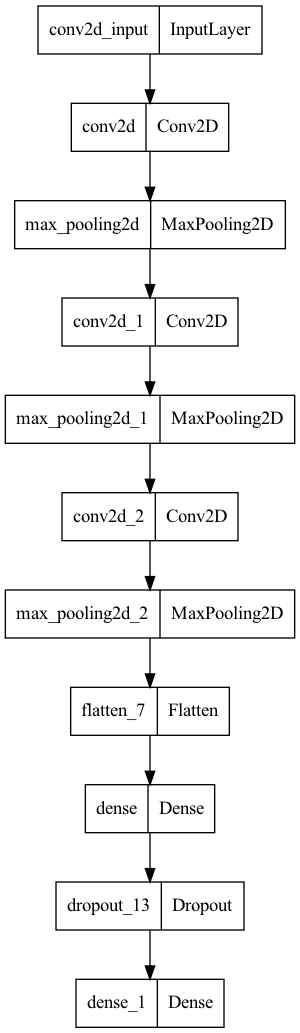

In [55]:
plot_model(model7)

Epoch 1/100
90/90 - 6s - loss: 0.4150 - accuracy: 0.8264 - val_loss: 0.2430 - val_accuracy: 0.9000 - 6s/epoch - 61ms/step
Epoch 2/100
90/90 - 5s - loss: 0.2549 - accuracy: 0.8934 - val_loss: 0.2267 - val_accuracy: 0.8958 - 5s/epoch - 57ms/step
Epoch 3/100
90/90 - 5s - loss: 0.1928 - accuracy: 0.9226 - val_loss: 0.1456 - val_accuracy: 0.9403 - 5s/epoch - 57ms/step
Epoch 4/100
90/90 - 5s - loss: 0.1562 - accuracy: 0.9455 - val_loss: 0.1960 - val_accuracy: 0.9139 - 5s/epoch - 60ms/step
Epoch 5/100
90/90 - 5s - loss: 0.1173 - accuracy: 0.9556 - val_loss: 0.1044 - val_accuracy: 0.9556 - 5s/epoch - 57ms/step
Epoch 6/100
90/90 - 5s - loss: 0.0931 - accuracy: 0.9698 - val_loss: 0.0817 - val_accuracy: 0.9639 - 5s/epoch - 57ms/step
Epoch 7/100
90/90 - 5s - loss: 0.0651 - accuracy: 0.9747 - val_loss: 0.0727 - val_accuracy: 0.9708 - 5s/epoch - 58ms/step
Epoch 8/100
90/90 - 6s - loss: 0.0538 - accuracy: 0.9823 - val_loss: 0.0437 - val_accuracy: 0.9889 - 6s/epoch - 61ms/step
Epoch 9/100
90/90 - 5s -

(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: title={'center': 'model7 model loss'}, xlabel='epoch', ylabel='loss'>,
        <Axes: title={'center': 'model7 model accuracy'}, xlabel='epoch', ylabel='accuracy'>],
       dtype=object))

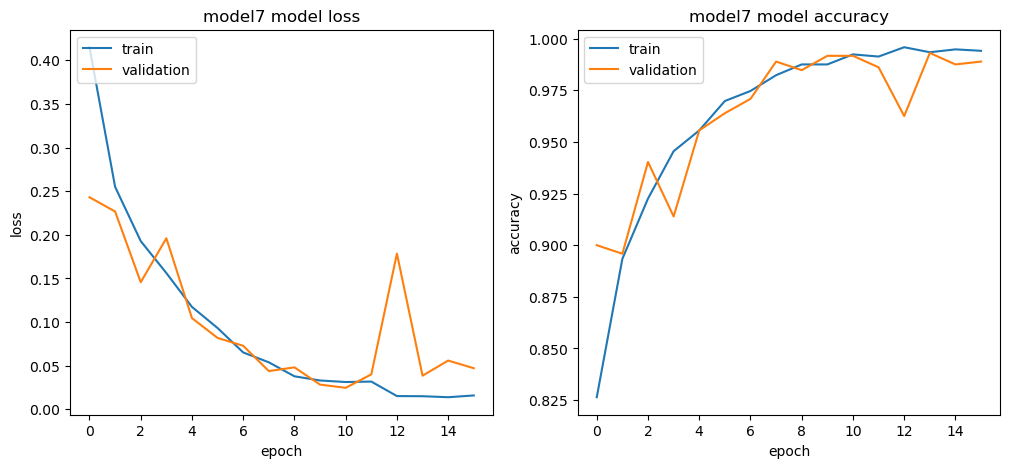

In [56]:
model7.compile(loss='binary_crossentropy', metrics=['accuracy'])
history7 = model7.fit(
    X_train_split, y_train_split,
    validation_data=(X_val_split, y_val_split),
    epochs=100,
    callbacks=[early_stop],
    verbose=2
)

helper.plotTrain(history7, model_name7)

In [57]:
score7 = model7.evaluate(X_test, y_test, verbose=0)
print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name7, l=score7[0], a=score7[1]))

model7: Test loss: 0.05 / Test accuracy: 0.99


Model7 performs exceptionally well, achieving a very low test loss of 0.05 and a high test accuracy of 99%. The training and validation loss curves show a steady decrease, indicating that the model learned effectively without overfitting. The accuracy also increases consistently, with validation accuracy closely following the training accuracy, suggesting good generalization. This result indicates that Model7 is well-suited for this classification task, capturing the necessary patterns in the data efficiently.

In [58]:
helper.saveModel(model7, model_name7)
helper.saveHistory(history7, model_name7)

Directory models already exists, files will be over-written.
Model saved in ./models/model7.keras; submit with your assignment.


### Idea 7: Try Data Augmentation
In this model, data augmentation is applied to improve the robustness of the model by generating additional, varied training data. The ImageDataGenerator is configured with transformations, including rotation, width and height shifts, shear, zoom, and horizontal flipping, which helps the model generalize better. The model architecture consists of three convolutional layers with increasing filters (32, 64, and 128) followed by max-pooling layers, flattening, and two dense layers, including a dropout layer to prevent overfitting.

In [59]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
model_name8="model8"
datagen = ImageDataGenerator(         
    rotation_range=10,          
    width_shift_range=0.1,      
    height_shift_range=0.1,     
    shear_range=0.1,            
    zoom_range=0.1,            
    horizontal_flip=True        
)

model8 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(80, 80, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

model8.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 78, 78, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 39, 39, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 18, 18, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 8, 128)       

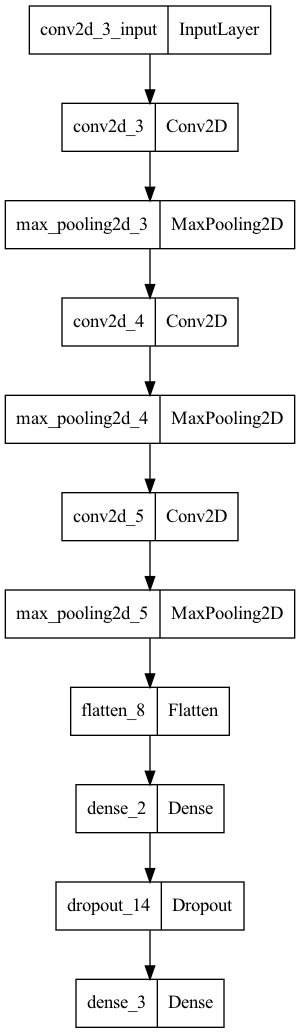

In [60]:
plot_model(model8)

Epoch 1/100


2024-10-28 13:19:46.935185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


90/90 - 6s - loss: 0.5088 - accuracy: 0.7691 - val_loss: 0.3448 - val_accuracy: 0.8306 - 6s/epoch - 68ms/step
Epoch 2/100
90/90 - 5s - loss: 0.3465 - accuracy: 0.8389 - val_loss: 0.2993 - val_accuracy: 0.8556 - 5s/epoch - 59ms/step
Epoch 3/100
90/90 - 5s - loss: 0.3129 - accuracy: 0.8549 - val_loss: 0.1978 - val_accuracy: 0.9222 - 5s/epoch - 59ms/step
Epoch 4/100
90/90 - 5s - loss: 0.2756 - accuracy: 0.8708 - val_loss: 0.1875 - val_accuracy: 0.9208 - 5s/epoch - 58ms/step
Epoch 5/100
90/90 - 5s - loss: 0.2661 - accuracy: 0.8819 - val_loss: 0.1788 - val_accuracy: 0.9264 - 5s/epoch - 58ms/step
Epoch 6/100
90/90 - 5s - loss: 0.2396 - accuracy: 0.8955 - val_loss: 0.1259 - val_accuracy: 0.9528 - 5s/epoch - 58ms/step
Epoch 7/100
90/90 - 5s - loss: 0.2315 - accuracy: 0.8990 - val_loss: 0.1581 - val_accuracy: 0.9403 - 5s/epoch - 58ms/step
Epoch 8/100
90/90 - 5s - loss: 0.1934 - accuracy: 0.9160 - val_loss: 0.0978 - val_accuracy: 0.9597 - 5s/epoch - 58ms/step
Epoch 9/100
90/90 - 5s - loss: 0.191

(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: title={'center': 'model8 model loss'}, xlabel='epoch', ylabel='loss'>,
        <Axes: title={'center': 'model8 model accuracy'}, xlabel='epoch', ylabel='accuracy'>],
       dtype=object))

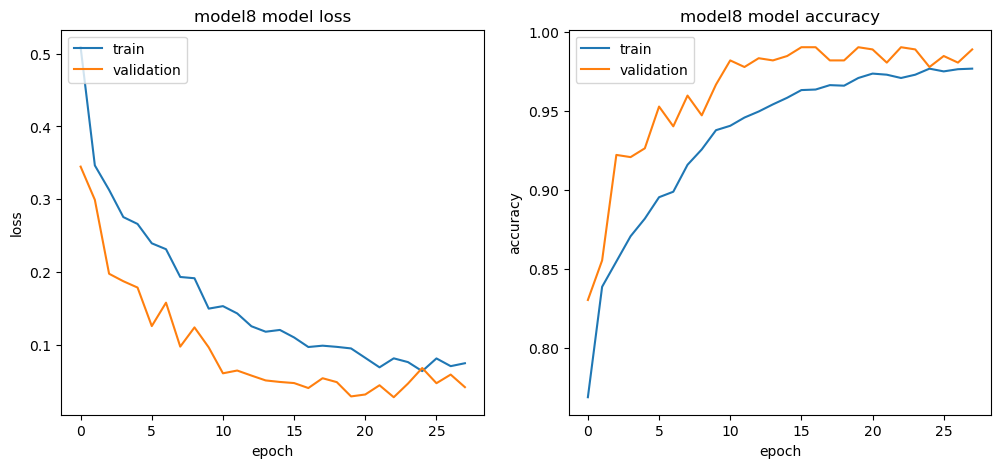

In [61]:
model8.compile(
              loss='binary_crossentropy',
              metrics=['accuracy'])

X_train_split_ = np.expand_dims(X_train_split, axis=-1)
X_val_split_ = np.expand_dims(X_val_split, axis=-1)

history8 = model8.fit(
    datagen.flow(X_train_split_, y_train_split, batch_size=32),
    validation_data=(X_val_split_, y_val_split),
    epochs=100,
    callbacks=[early_stop],
    verbose=2
)


helper.plotTrain(history8, model_name8)

In [62]:
X_test_ = np.expand_dims(X_test, axis=-1)
score8 = model8.evaluate(X_test_, y_test, verbose=0)
print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name8, l=score8[0], a=score8[1]))

model8: Test loss: 0.03 / Test accuracy: 0.99


Model 8 performed excellently, achieving a very low test loss of 0.03 and an impressive test accuracy of 99%. The training and validation curves show smooth and consistent learning, with both loss and accuracy stabilizing at high performance levels without major signs of overfitting. The data augmentation strategy appears to have contributed to the model's strong generalization ability, maintaining high accuracy on unseen data. This result indicates that the model is both accurate and robust.

In [63]:
helper.saveModel(model8, model_name8)
helper.saveHistory(history8, model_name8)

Directory models already exists, files will be over-written.
Model saved in ./models/model8.keras; submit with your assignment.


### Idea 8: Try leveraging Transfer Learning with VGG16 for Enhanced Image Classification
This model uses transfer learning with the VGG16 architecture pre-trained on the ImageNet dataset to improve image classification. The VGG16 base model's layers are frozen to retain the learned features, focusing only on training the added custom layers. After the VGG16 layers, the model includes a Flatten layer followed by two Dense layers—one with 64 units and ReLU activation, and a final Dense layer with 1 unit and sigmoid activation for binary classification. This setup allows the model to leverage VGG16’s powerful feature extraction capabilities while adapting to the specific classification task at hand, potentially improving accuracy and training efficiency.

In [64]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(80, 80, 3))

for layer in base_model.layers:
    layer.trainable = False

model_name9="model9"
model9 = Sequential([
    base_model,
    Flatten(),
    Dense(64, activation='relu', name='dense_1'),
    Dropout(0.1),
    Dense(1, activation='sigmoid', name='output')
])

model9.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_9 (Flatten)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 64)                131136    
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 14,845,889
Trainable params: 131,201
Non-trainable params: 14,714,688
_________________________________________________________________


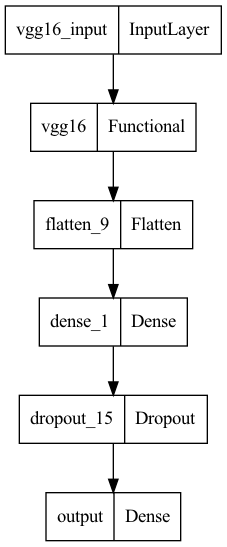

In [65]:
plot_model(model9)

In [66]:
X_train_rgb,X_test_rgb, y_train_rgb, y_test_rgb = train_test_split(data, labels, test_size=0.2, random_state=42)
X_train_split_rgb, X_val_split_rgb, y_train_split_rgb, y_val_split_rgb = train_test_split(X_train_rgb, y_train_rgb, test_size=0.2, random_state=42)

Epoch 1/100


2024-10-28 13:22:19.118401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


80/80 - 41s - loss: 0.4404 - accuracy: 0.9410 - val_loss: 0.3607 - val_accuracy: 0.9484 - 41s/epoch - 513ms/step
Epoch 2/100
80/80 - 40s - loss: 0.1579 - accuracy: 0.9723 - val_loss: 0.0883 - val_accuracy: 0.9859 - 40s/epoch - 502ms/step
Epoch 3/100
80/80 - 39s - loss: 0.1110 - accuracy: 0.9785 - val_loss: 0.0863 - val_accuracy: 0.9875 - 39s/epoch - 488ms/step
Epoch 4/100
80/80 - 39s - loss: 0.1033 - accuracy: 0.9820 - val_loss: 0.0602 - val_accuracy: 0.9859 - 39s/epoch - 493ms/step
Epoch 5/100
80/80 - 39s - loss: 0.0619 - accuracy: 0.9875 - val_loss: 0.0319 - val_accuracy: 0.9875 - 39s/epoch - 486ms/step
Epoch 6/100
80/80 - 55s - loss: 0.0844 - accuracy: 0.9875 - val_loss: 0.0376 - val_accuracy: 0.9906 - 55s/epoch - 682ms/step
Epoch 7/100
80/80 - 58s - loss: 0.0466 - accuracy: 0.9891 - val_loss: 0.0240 - val_accuracy: 0.9922 - 58s/epoch - 722ms/step
Epoch 8/100
80/80 - 54s - loss: 0.0584 - accuracy: 0.9891 - val_loss: 0.0240 - val_accuracy: 0.9937 - 54s/epoch - 677ms/step
Epoch 9/100


(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: title={'center': 'model9 model loss'}, xlabel='epoch', ylabel='loss'>,
        <Axes: title={'center': 'model9 model accuracy'}, xlabel='epoch', ylabel='accuracy'>],
       dtype=object))

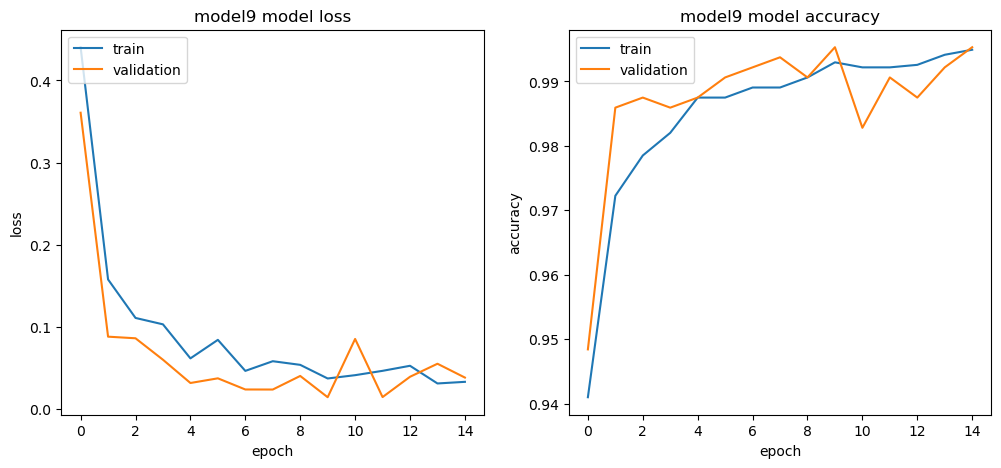

In [67]:
model9.compile(
              loss='binary_crossentropy',
              metrics=['accuracy'])

history9 = model9.fit(
    datagen.flow(X_train_split_rgb, y_train_split_rgb, batch_size=32),
    validation_data=(X_val_split_rgb, y_val_split_rgb),
    epochs=100,
    callbacks=[early_stop],
    verbose=2
)
helper.plotTrain(history9, model_name9)

In [68]:
score9 = model9.evaluate(X_test_rgb, y_test_rgb, verbose=0)
print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name9, l=score9[0], a=score9[1]))

model9: Test loss: 0.01 / Test accuracy: 1.00


Model 9 demonstrates excellent performance, achieving a test loss of 0.01 and an impressive test accuracy of 100%.  The training and validation loss curves decrease smoothly, and the accuracy graphs show convergence near the maximum accuracy level, indicating effective training with minimal overfitting.  This outcome highlights the benefits of using a pre-trained VGG16 model, which effectively leverages transfer learning to handle the specific dataset, achieving high accuracy and generalization.

In [69]:
helper.saveModel(model9, model_name9)
helper.saveHistory(history9, model_name9)

Directory models already exists, files will be over-written.
Model saved in ./models/model9.keras; submit with your assignment.


### Idea 9: Try Batch Normalization
Model 10 introduces batch normalization after each convolutional layer, which aims to stabilize and accelerate the training process. The architecture consists of three convolutional blocks, each with a Conv2D layer, batch normalization, and max pooling, followed by a flattening layer. The fully connected (dense) part of the network includes a single hidden layer with 64 units and a dropout layer for regularization, ending with an output layer for binary classification. The inclusion of batch normalization is expected to improve convergence and make the model more robust to variations in input data distribution.

In [70]:
from tensorflow.keras.layers import BatchNormalization

model_name10="model10"
model10 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(80, 80, 1)),
    BatchNormalization(),  
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),  
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),  
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(64, activation='relu'),
    BatchNormalization(),  
    Dropout(0.1),

    Dense(1, activation='sigmoid')  
])

model10.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 78, 78, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 78, 78, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 39, 39, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 37, 37, 64)       256       
 hNormalization)                                                 
                                                     

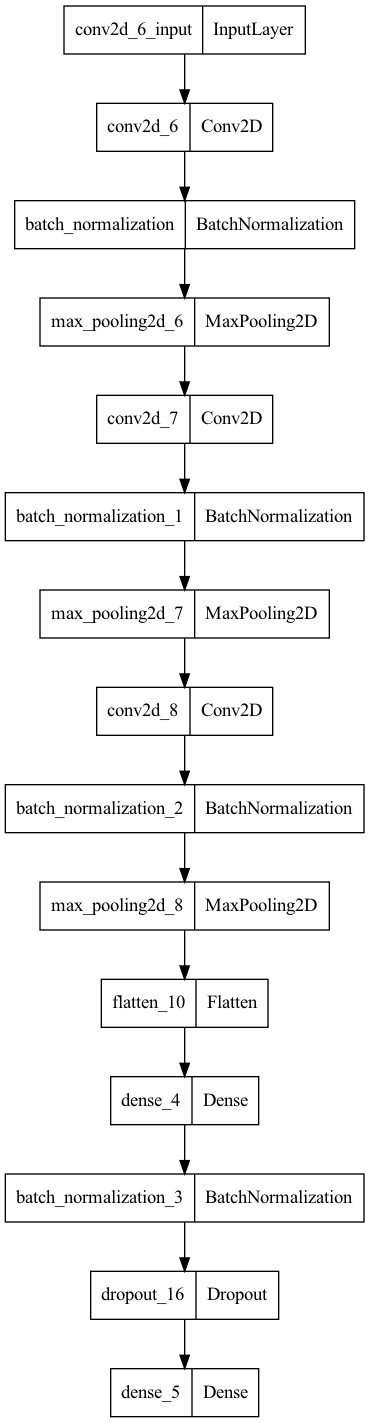

In [71]:
plot_model(model10)

Epoch 1/100
90/90 - 8s - loss: 0.2681 - accuracy: 0.9167 - val_loss: 0.7252 - val_accuracy: 0.7472 - 8s/epoch - 84ms/step
Epoch 2/100
90/90 - 7s - loss: 0.0927 - accuracy: 0.9729 - val_loss: 0.7820 - val_accuracy: 0.7472 - 7s/epoch - 83ms/step
Epoch 3/100
90/90 - 7s - loss: 0.0460 - accuracy: 0.9875 - val_loss: 0.9518 - val_accuracy: 0.7486 - 7s/epoch - 76ms/step
Epoch 4/100
90/90 - 7s - loss: 0.0243 - accuracy: 0.9931 - val_loss: 0.5785 - val_accuracy: 0.8181 - 7s/epoch - 75ms/step
Epoch 5/100
90/90 - 7s - loss: 0.0182 - accuracy: 0.9944 - val_loss: 0.5816 - val_accuracy: 0.8139 - 7s/epoch - 75ms/step
Epoch 6/100
90/90 - 7s - loss: 0.0136 - accuracy: 0.9962 - val_loss: 0.1826 - val_accuracy: 0.9347 - 7s/epoch - 76ms/step
Epoch 7/100
90/90 - 7s - loss: 0.0105 - accuracy: 0.9969 - val_loss: 0.0715 - val_accuracy: 0.9694 - 7s/epoch - 75ms/step
Epoch 8/100
90/90 - 7s - loss: 0.0143 - accuracy: 0.9962 - val_loss: 0.3225 - val_accuracy: 0.9139 - 7s/epoch - 76ms/step
Epoch 9/100
90/90 - 7s -

(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: title={'center': 'model10 model loss'}, xlabel='epoch', ylabel='loss'>,
        <Axes: title={'center': 'model10 model accuracy'}, xlabel='epoch', ylabel='accuracy'>],
       dtype=object))

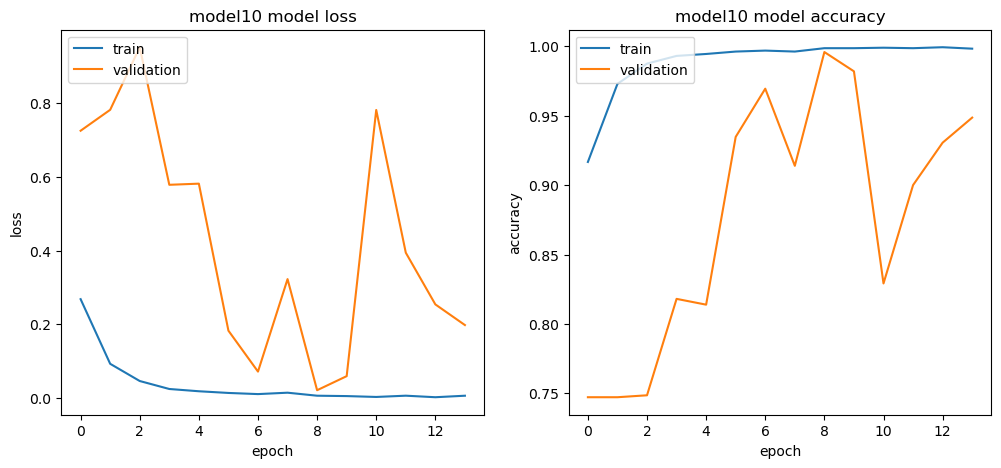

In [72]:
model10.compile(loss='binary_crossentropy', metrics=['accuracy'])
history10 = model10.fit(
    X_train_split, y_train_split,
    validation_data=(X_val_split, y_val_split),
    epochs=100,
    callbacks=[early_stop],
    verbose=2
)

helper.plotTrain(history10, model_name10)

In [73]:
score10 = model10.evaluate(X_test, y_test, verbose=0)
print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name10, l=score10[0], a=score10[1]))

model10: Test loss: 0.05 / Test accuracy: 0.99


Model 10 achieves strong performance with a very low test loss of 0.05 and high test accuracy of 99%.  The training and validation loss curves show downward trends.  Batch normalization likely helped in stabilizing the training process, contributing to this high accuracy by normalizing feature distributions after each layer.  Overall, the model performs well, suggesting that the architecture is effective for this classification task.

In [74]:
helper.saveModel(model10, model_name10)
helper.saveHistory(history10, model_name10)

Directory models already exists, files will be over-written.
Model saved in ./models/model10.keras; submit with your assignment.


### Idea 10: Try different optimizers and learning rates
In this setup, Model 11 is being evaluated with three different optimizers: Adam, SGD (Stochastic Gradient Descent), and RMSprop.  Each configuration includes batch normalization, dropout layers for regularization, and a custom learning rate scheduler that reduces the learning rate by half every 5 epochs.  This model aims to enhance training stability and performance by trying different optimizers with dynamically adjusted learning rates. 

Epoch 1/100
90/90 - 7s - loss: 0.3145 - accuracy: 0.8858 - val_loss: 0.9525 - val_accuracy: 0.7472 - lr: 0.0010 - 7s/epoch - 82ms/step
Epoch 2/100
90/90 - 7s - loss: 0.1264 - accuracy: 0.9653 - val_loss: 0.9295 - val_accuracy: 0.7472 - lr: 0.0010 - 7s/epoch - 76ms/step
Epoch 3/100
90/90 - 7s - loss: 0.0620 - accuracy: 0.9868 - val_loss: 0.8172 - val_accuracy: 0.7583 - lr: 0.0010 - 7s/epoch - 75ms/step
Epoch 4/100
90/90 - 7s - loss: 0.0305 - accuracy: 0.9951 - val_loss: 0.2303 - val_accuracy: 0.8875 - lr: 0.0010 - 7s/epoch - 75ms/step
Epoch 5/100
90/90 - 7s - loss: 0.0312 - accuracy: 0.9944 - val_loss: 0.3892 - val_accuracy: 0.8486 - lr: 0.0010 - 7s/epoch - 75ms/step
Epoch 6/100
90/90 - 7s - loss: 0.0214 - accuracy: 0.9955 - val_loss: 0.0691 - val_accuracy: 0.9722 - lr: 5.0000e-04 - 7s/epoch - 75ms/step
Epoch 7/100
90/90 - 7s - loss: 0.0118 - accuracy: 0.9986 - val_loss: 0.0300 - val_accuracy: 0.9931 - lr: 5.0000e-04 - 7s/epoch - 75ms/step
Epoch 8/100
90/90 - 7s - loss: 0.0087 - accurac

(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: title={'center': 'model11 model loss'}, xlabel='epoch', ylabel='loss'>,
        <Axes: title={'center': 'model11 model accuracy'}, xlabel='epoch', ylabel='accuracy'>],
       dtype=object))

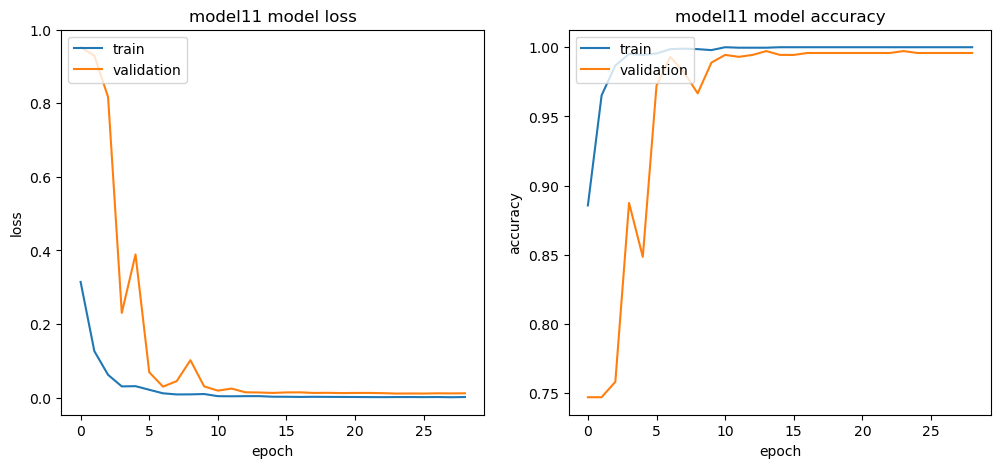

In [75]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch % 5 == 0 and epoch != 0:
        return lr * 0.5
    return lr

model_name11="model11"
model11 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(80, 80, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])



model11.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


lr_scheduler = LearningRateScheduler(scheduler)

history11 = model11.fit(
    X_train_split, y_train_split,
    epochs=100,
    validation_data=(X_val_split, y_val_split),
    callbacks=[lr_scheduler, early_stop], 
    verbose=2
)

helper.plotTrain(history11, model_name11)

In [76]:
score11 = model11.evaluate(X_test, y_test, verbose=0)
print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name11, l=score11[0], a=score11[1]))

model11: Test loss: 0.02 / Test accuracy: 0.99


Epoch 1/100
90/90 - 7s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0119 - val_accuracy: 0.9958 - lr: 0.0100 - 7s/epoch - 80ms/step
Epoch 2/100
90/90 - 7s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0122 - val_accuracy: 0.9958 - lr: 0.0100 - 7s/epoch - 75ms/step
Epoch 3/100
90/90 - 7s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0141 - val_accuracy: 0.9958 - lr: 0.0100 - 7s/epoch - 75ms/step
Epoch 4/100
90/90 - 7s - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0117 - val_accuracy: 0.9958 - lr: 0.0100 - 7s/epoch - 74ms/step
Epoch 5/100
90/90 - 7s - loss: 0.0050 - accuracy: 0.9990 - val_loss: 0.0137 - val_accuracy: 0.9944 - lr: 0.0100 - 7s/epoch - 76ms/step
Epoch 6/100
90/90 - 7s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0121 - val_accuracy: 0.9958 - lr: 0.0050 - 7s/epoch - 75ms/step
Epoch 7/100
90/90 - 7s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0117 - val_accuracy: 0.9958 - lr: 0.0050 - 7s/epoch - 75ms/step
Epoch 8/100
90/90 - 7s - loss: 0.0016 - accuracy: 1.000

(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: title={'center': 'model11 model loss'}, xlabel='epoch', ylabel='loss'>,
        <Axes: title={'center': 'model11 model accuracy'}, xlabel='epoch', ylabel='accuracy'>],
       dtype=object))

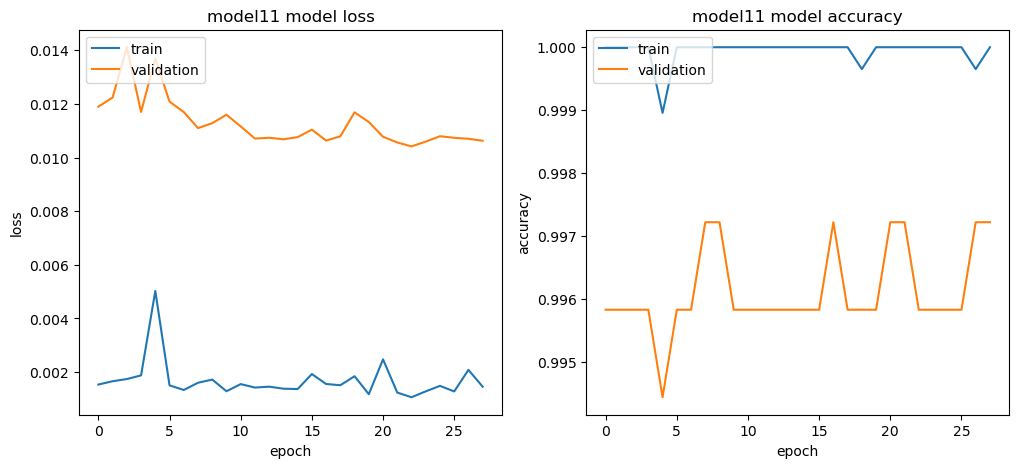

In [77]:
model11.compile(optimizer=SGD(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

history12 = model11.fit(
    X_train_split, y_train_split,
    epochs=100,
    validation_data=(X_val_split, y_val_split),
    callbacks=[lr_scheduler, early_stop], 
    verbose=2
)

helper.plotTrain(history12, model_name11)

In [78]:
score12 = model11.evaluate(X_test, y_test, verbose=0)
print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name11, l=score12[0], a=score12[1]))

model11: Test loss: 0.02 / Test accuracy: 0.99


Epoch 1/100
90/90 - 7s - loss: 0.0245 - accuracy: 0.9913 - val_loss: 0.1001 - val_accuracy: 0.9667 - lr: 0.0010 - 7s/epoch - 80ms/step
Epoch 2/100
90/90 - 7s - loss: 0.0199 - accuracy: 0.9924 - val_loss: 0.0758 - val_accuracy: 0.9694 - lr: 0.0010 - 7s/epoch - 77ms/step
Epoch 3/100
90/90 - 7s - loss: 0.0082 - accuracy: 0.9972 - val_loss: 0.0188 - val_accuracy: 0.9931 - lr: 0.0010 - 7s/epoch - 76ms/step
Epoch 4/100
90/90 - 7s - loss: 0.0087 - accuracy: 0.9983 - val_loss: 0.0386 - val_accuracy: 0.9861 - lr: 0.0010 - 7s/epoch - 74ms/step
Epoch 5/100
90/90 - 7s - loss: 0.0158 - accuracy: 0.9972 - val_loss: 0.2578 - val_accuracy: 0.9208 - lr: 0.0010 - 7s/epoch - 75ms/step
Epoch 6/100
90/90 - 7s - loss: 0.0040 - accuracy: 0.9990 - val_loss: 0.0575 - val_accuracy: 0.9861 - lr: 5.0000e-04 - 7s/epoch - 76ms/step
Epoch 7/100
90/90 - 7s - loss: 8.7327e-04 - accuracy: 1.0000 - val_loss: 0.0218 - val_accuracy: 0.9917 - lr: 5.0000e-04 - 7s/epoch - 76ms/step
Epoch 8/100
90/90 - 7s - loss: 0.0014 - acc

(<Figure size 1200x500 with 2 Axes>,
 array([<Axes: title={'center': 'model11 model loss'}, xlabel='epoch', ylabel='loss'>,
        <Axes: title={'center': 'model11 model accuracy'}, xlabel='epoch', ylabel='accuracy'>],
       dtype=object))

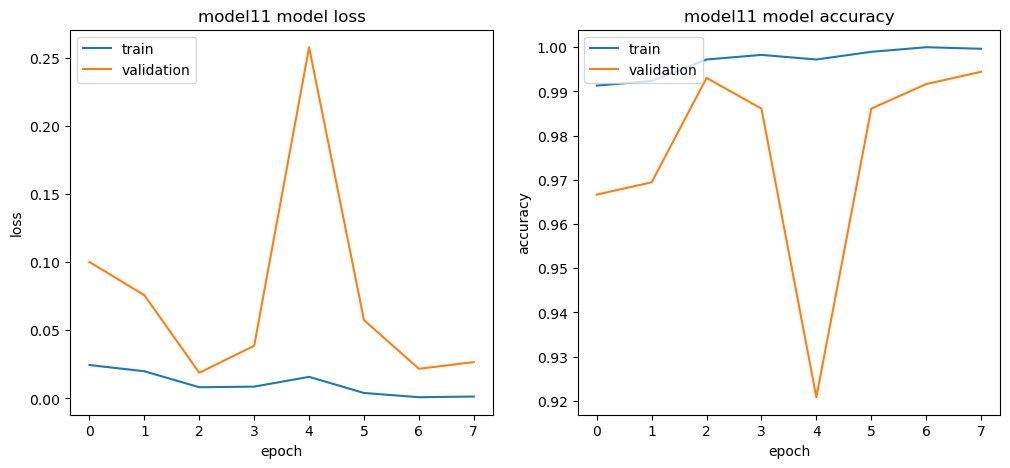

In [79]:
model11.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history13 = model11.fit(
    X_train_split, y_train_split,
    epochs=100,
    validation_data=(X_val_split, y_val_split),
    callbacks=[lr_scheduler, early_stop], 
    verbose=2
)

helper.plotTrain(history13, model_name11)

In [80]:
score13 = model11.evaluate(X_test, y_test, verbose=0)
print("{n:s}: Test loss: {l:3.2f} / Test accuracy: {a:3.2f}".format(n=model_name11, l=score13[0], a=score13[1]))

model11: Test loss: 0.02 / Test accuracy: 0.99


The three models show high performance with test accuracy values of approximately 0.99, indicating effective learning across all optimizer setups.  Model11, with a test loss around 0.02 and consistent accuracy across Adam, SGD, and RMSprop optimizers, demonstrates robustness in achieving minimal loss while maintaining near-perfect accuracy.  The graphs indicate stable training and validation accuracy for each model configuration, though some fluctuations in validation accuracy are observed, particularly in models with RMSprop and SGD.  Overall, the use of batch normalization, learning rate scheduling, and dropout contributed to preventing overfitting and achieving excellent generalization.

In [81]:
helper.saveModel(model11, model_name11)
helper.saveHistory(history12, model_name11)

Directory models already exists, files will be over-written.
Model saved in ./models/model11.keras; submit with your assignment.
